# Recommender System

Coca-Cola: Plan a personalized campaign targeting customers purchasing from other carbonated soft drink (CSD) brands

We recommend Coca-Cola CSD products to customers who: 

    - Buy other CSDs
    - Do NOT buy Coca-Cola
    - Do NOT buy ACSE brand of product

Ensures that promotional offers go only to new potential Coca-Cola buys who are loyal to ther soda brands

In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv("data_sampling_clean.csv")

In [2]:
# df but only with customers who made 5+ purchases in the last 6 mo
df = pd.read_csv("smaller_data_sample.csv")

In [3]:
products = pd.read_csv("products.csv")

In [4]:
# Merge product info into transactions
df = df.merge(products, on='prod_id', how='left')
og = df

In [33]:
# Use if need to reset df without reloading
# df = og

In [5]:
df.shape

(105138914, 17)

In [6]:
df.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
0,180713010000509098,2018-07-13,1000,1127170871,20308979,7.98,2,0.0,SILK SOY BEV UNSWTN,Natural Foods,Natural Foods,Dairy-Natural Foods,Beverages,SILK,1.0,L,1.89
1,191006010000503067,2019-10-06,1000,1101884014,20907159,7.99,1,0.0,MDR RAW WLD SHRIMP EZP 20/30,Seafood,Frozen Seafood,Shrimp,Raw,UNBR,1.0,G,300.00
2,180922010002807277,2018-09-22,1000,1130022329,20103461,7.99,1,0.0,SD PROSCIUTTO PPK,Deli,Deli Meat,Self Serve Deli Meat,Prosciutto,SAND,1.0,G,125.00
3,171023010002409370,2017-10-23,1000,1125092457,20896874,9.99,1,0.0,ACSE EX LATEX MED EXAM GLVES,OTC,Wellness,First Aid Products,Masks & Gloves,ACSE,1.0,EA,50.00
4,200126010002501135,2020-01-26,1000,1146746379,21084801,7.99,1,0.0,LYSOL LDRY SNTZER CRSP LN,Grocery,Household Cleaning Needs,Laundry-Household Cl,Laundry Additive,LYSL,1.0,L,1.20


# Coca-Cola Exploratory Data Analysis

### Preliminary / Seasonality

In [12]:
# How many unique Coke products?
coke_df = df[df['prod_mfc_brand_cd'] == 'COCA']
print("Unique Coke Products:", coke_df['prod_id'].nunique())

# Total Coke transactions
print("Total Coke Transactions:", len(coke_df))

# Unique customers who bought Coke
coke_customers = coke_df['cust_id'].unique()
print("Customers who purchased Coke:", len(coke_customers))


Unique Coke Products: 89
Total Coke Transactions: 453154
Customers who purchased Coke: 91640


In [15]:
pip install dask

Note: you may need to restart the kernel to use updated packages.


In [26]:
import dask.dataframe as dd
df_dask = dd.read_csv("smaller_data_sample.csv")

In [27]:
df = df_dask.merge(products, on='prod_id', how='left')
og = df

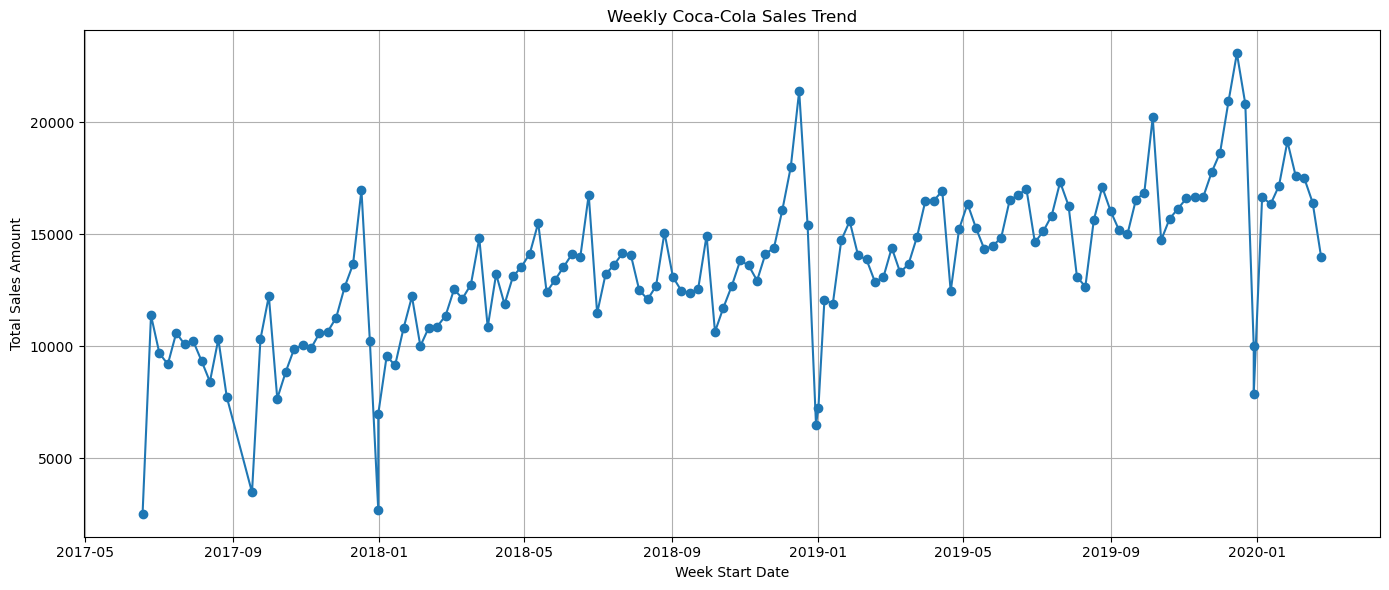

In [30]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Filter to Coca-Cola purchases
coke_df = df[df['prod_mfc_brand_cd'] == 'COCA']

# Step 1: Ensure datetime column
coke_df['trans_dt'] = dd.to_datetime(coke_df['trans_dt'])

# Step 2: Create year-week grouping string
coke_df['year_week'] = coke_df['trans_dt'].dt.strftime('%Y-%U')

# Step 3: Aggregate sales
weekly_sales = coke_df.groupby('year_week')['sales_amt'].sum()

# Step 4: Compute to pandas
weekly_sales_pd = weekly_sales.compute().reset_index()

# Step 5: Optional — convert year_week back to datetime (e.g., start of the week)
weekly_sales_pd['week_start'] = pd.to_datetime(weekly_sales_pd['year_week'] + '-0', format='%Y-%U-%w')  # 0 = Sunday

# Step 6: Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(weekly_sales_pd['week_start'], weekly_sales_pd['sales_amt'], marker='o')
plt.title("Weekly Coca-Cola Sales Trend")
plt.xlabel("Week Start Date")
plt.ylabel("Total Sales Amount")
plt.grid(True)
plt.tight_layout()
plt.show()



    - Upward sales trend over time
    - Strong seasonal spikes: notable sales spiles around year-end holidays November/December...
    - Suggests coke is a popular product during holday periods likely due to celebrations and family gatherings
    - Sudden dips after peaks, reflecting post-holiday sales slump: fewer gatherings, consumer spending pullback after holidays, potential seasonal inventory reduction
    - Regular fluctuation patter

### Understanding Co-Purchase Patterns

In [26]:
competitors = df[df['prod_subcategory'] == 'Carbonated Soft Drin']['prod_mfc_brand_cd'].value_counts()
print(competitors)

prod_mfc_brand_cd
COCA    146781
CDRY     75632
ACSE     68016
PEPS     52214
SPIT     17274
SCH      16063
ANW       8872
FRSA      8479
CRUS      7522
DRPR      7185
7UP       6253
FAN       5472
MTND      4139
LPTN      2729
BARQ      2724
GRCE      2616
GJAM      2031
MUG       1828
BRSK      1590
BRIO       962
VRNR       773
FREE       561
MARP       514
CPLS       401
TIGR       358
JRRT       352
DG00       330
WHRO       299
BARC       217
NTEA       216
COOL       172
RUBI       162
OLDJ       158
LOTT        68
POWR        66
FROT        59
PUHE        52
VALT        33
FNTI        16
STWT        15
CLIC        12
LAZZ        11
JNS          9
PAKO         8
SOLO         5
GATO         5
COTB         4
MKSP         3
CHBB         2
INCA         1
Name: count, dtype: int64


In [7]:
# Step 1: Identify Coke customers
coke_customers = df[df['prod_mfc_brand_cd'] == 'COCA']['cust_id'].unique()

# Step 2: Filter full transaction history for those customers
coke_cust_history = df[df['cust_id'].isin(set(coke_customers))]

# Step 3: Exclude Coca-Cola transactions to focus on co-purchases
non_coke_txns = coke_cust_history[coke_cust_history['prod_mfc_brand_cd'] != 'COCA']

In [ ]:
# Step 4: Compute top product categories and brands
top_categories = non_coke_txns['prod_category'].value_counts().nlargest(10).compute()
top_brands = non_coke_txns['prod_mfc_brand_cd'].value_counts().nlargest(10).compute()

# Step 5: Print results
print("Top Product Categories Also Bought by Coke Customers:")
print(top_categories)

print("\nTop Brands Also Bought by Coke Customers:")
print(top_brands)


Top Product Categories Also Bought by Coke Customers:
prod_category
Vegetables                 8172063
Fruit                      5577368
Snacks                     3698010
Natural Foods              2750746
Milk & Eggs                2344405
In-Store                   2336325
Cold Beverages             2226620
Commercial                 2122170
Meal Makers                1973659
Cheese/Butter/Margarine    1893736
Name: count, dtype: int64[pyarrow]

Top Brands Also Bought by Coke Customers:
prod_mfc_brand_cd
ACSE    19886335
UNBR     8982509
NLSN     1441685
POTM      649324
KRFT      622185
CHRE      483296
CAMS      455155
NSTL      399038
DOLE      390689
KLGS      383869
Name: count, dtype: int64[pyarrow]


In [ ]:
top_products = non_coke_txns['prod_desc'].value_counts().nlargest(30).compute()

# Print results
print("Top Products Also Bought by Coke Customers:")
print(top_products)


Top Products Also Bought by Coke Customers:
prod_desc
BANANA                               998194
CUCUMBER ENGLISH                     317169
ACSE GRADE A EGGS LARGE WHITE, EA    259881
PEPPERS RED SWEET                    228842
BROCCOLI                             225259
AVOCADO BULK                         223272
LEMON                                209002
RASPBERRIES 1/2 PINT                 193997
ONION GREEN                          188033
STRAWBERRIES 1LB                     187798
TOMATO ON THE VINE RED               187006
NEILSON MILK 2% BAG                  185265
GRAPE GREEN SEEDLESS                 181725
TOMATO BEEFSTEAK RED                 175591
NEILSON PARTLY SKIM MILK 1%          174157
GRAPE RED SEEDLESS                   165379
ACSE BANANA ORGANIC                  153892
BLUEBERRIES PINTS                    151330
LIME                                 145821
ZUCCHINI GREEN                       136040
ONION RED                            135084
CELERY STALKS         

In [ ]:
# Compute top product categories and brands

top_subcat = non_coke_txns['prod_subcategory'].value_counts().nlargest(10).compute()
top_types = non_coke_txns['prod_type'].value_counts().nlargest(10).compute()

# Print results
print("Top Product Sub-Categories Also Bought by Coke Customers:")
print(top_subcat)

print("Top Product Types Also Bought by Coke Customers:")
print(top_types)

Top Product Sub-Categories Also Bought by Coke Customers:
prod_subcategory
Root Veg            2058455
Milk                1617570
Salty Snacks        1537782
Cheese              1452703
Field Veg           1452373
Berries/Cherries    1243401
Bananas             1164792
Cooking Veg         1131807
Yogurt              1102560
Deli Cheese         1088392
Name: count, dtype: int64[pyarrow]
Top Product Types Also Bought by Coke Customers:
prod_type
Yellow       1526717
Family       1359760
Premium      1335668
Regular       775901
Specialty     727324
Potato        724833
Core Milk     625131
Adult         565153
Kids          564600
Cans          536149
Name: count, dtype: int64[pyarrow]


Average Transactions per Customer: 69.5848335348123
Average Basket Size: 9.578155959770493


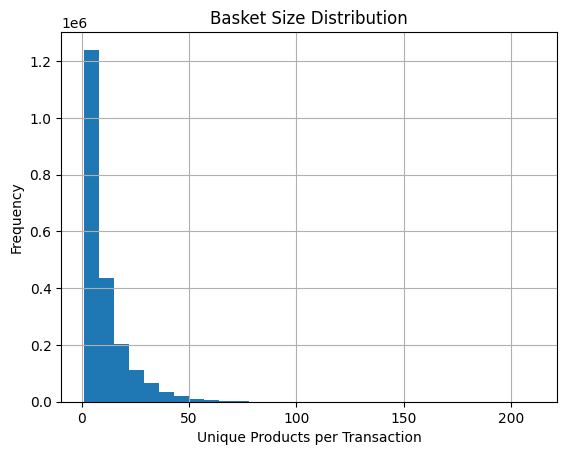

In [8]:
# Basket size and frequency analysis

# Transactions per customer
transactions_per_cust = coke_cust_history.groupby('cust_id')['trans_id'].nunique()
print("Average Transactions per Customer:", transactions_per_cust.mean())

# Basket size (items per transaction)
items_per_transaction = coke_cust_history.groupby('trans_id')['prod_id'].nunique()
print("Average Basket Size:", items_per_transaction.mean())

# Plot basket size distribution
import matplotlib.pyplot as plt
items_per_transaction.hist(bins=30)
plt.title("Basket Size Distribution")
plt.xlabel("Unique Products per Transaction")
plt.ylabel("Frequency")
plt.show()


In [9]:
# Co-purchase patterns (brand or category)
# For each transaction, get list of brands or categories (choose one)
brand_baskets = coke_cust_history.groupby('trans_id')['prod_mfc_brand_cd'].apply(lambda x: list(set(x)))
category_baskets = coke_cust_history.groupby('trans_id')['prod_category'].apply(lambda x: list(set(x)))

# Frequency of brand combinations
from itertools import combinations
from collections import Counter

brand_pairs = Counter()
for basket in brand_baskets:
    for pair in combinations(sorted(basket), 2):
        brand_pairs[pair] += 1

# Most frequent co-purchased brand pairs with COCA
coke_brand_pairs = {k: v for k, v in brand_pairs.items() if 'COCA' in k}
print("Top Brand Co-Purchases with Coca-Cola:")
print(sorted(coke_brand_pairs.items(), key=lambda x: x[1], reverse=True)[:10])


Top Brand Co-Purchases with Coca-Cola:
[(('ACSE', 'COCA'), 115937), (('COCA', 'UNBR'), 76445), (('COCA', 'NLSN'), 37445), (('COCA', 'KRFT'), 17906), (('CDRY', 'COCA'), 16169), (('COCA', 'POTM'), 15577), (('CHRE', 'COCA'), 14178), (('COCA', 'NSTL'), 13022), (('COCA', 'WNDR'), 11409), (('COCA', 'KLGS'), 11338)]


In [ ]:
# Customer Segmentation Starter (RFM-style)
# Recency, Frequency, Monetary for Coke customers
rfm = coke_cust_history.groupby('cust_id').agg({
    'trans_dt': lambda x: (coke_cust_history['trans_dt'].max() - x.max()).days,
    'trans_id': 'nunique',
    'sales_amt': 'sum'
}).rename(columns={'trans_dt': 'Recency', 'trans_id': 'Frequency', 'sales_amt': 'Monetary'})

print("RFM Sample:")
print(rfm.head())


In [ ]:
# We can automatically remove these noisy products using lift, a standard metric 
# from association rule mining:
# Lift = (P(A and B)) / (P(A) * P(B))
#  If a product appears often across all baskets, but not especially often 
# with Coke, it will have a low lift.
# If a product appears more often with Coke than expected, it will have high 
# lift → a true signal.

# Count total customers who bought each product
total_customers = df['cust_id'].nunique()

# Product purchase frequency across all customers
prod_global_freq = df.groupby('prod_desc')['cust_id'].nunique().rename("global_count")

# Product purchase frequency among Coke customers only
coke_customers = df[df['prod_mfc_brand_cd'] == 'COCA']['cust_id'].unique()
coke_df = df[df['cust_id'].isin(coke_customers)]
prod_coke_freq = coke_df.groupby('prod_desc')['cust_id'].nunique().rename("coke_count")

# Combine into one DataFrame
lift_df = pd.concat([prod_coke_freq, prod_global_freq], axis=1).fillna(0)
lift_df['P(B)'] = lift_df['global_count'] / total_customers
lift_df['P(B|A)'] = lift_df['coke_count'] / len(coke_customers)
lift_df['lift'] = lift_df['P(B|A)'] / lift_df['P(B)']

# Filter to products with lift > 1.1 (adjustable threshold)
top_lifted = lift_df[lift_df['lift'] > 1.1].sort_values(by='coke_count', ascending=False)

print("Top Informative Products Bought by Coke Customers:")
print(top_lifted[['coke_count', 'global_count', 'lift']].head(20))


Top Informative Products Bought by Coke Customers:
                                   coke_count  global_count      lift
prod_desc                                                            
BANANA                                21448.0         61311  1.395223
CUCUMBER ENGLISH                      15350.0         36373  1.683157
TOMATO ON THE VINE RED                13149.0         30700  1.708243
LEMON                                 13029.0         30103  1.726222
ACSE GRADE A EGGS LARGE WHITE, EA     13021.0         30866  1.682516
TOMATO BEEFSTEAK RED                  12902.0         28997  1.774595
STRAWBERRIES 1LB                      12772.0         28104  1.812534
PEPPERS RED SWEET                     12683.0         28789  1.757077
BROCCOLI                              12493.0         29246  1.703710
ONION GREEN                           11788.0         26259  1.790430
AVOCADO BULK                          11783.0         28610  1.642606
GRAPE GREEN SEEDLESS                  1

In [16]:
import numpy as np
lift_df['importance'] = lift_df['lift'] * np.log1p(lift_df['coke_count'])
filtered = lift_df[(lift_df['lift'] >= 1.5) & (lift_df['coke_count'] >= 50)].sort_values(by='importance', ascending=False)
print(filtered[['coke_count', 'global_count', 'lift', 'importance']].head(20))

                                coke_count  global_count      lift  importance
prod_desc                                                                     
COCA-COLA FRIDGEMATE                7526.0          7526  3.988369   35.601183
COCA-COLA CLASSIC                   5292.0          5292  3.988369   34.196833
COCA-COLA                           5279.0          5279  3.988369   34.187025
Coca-Cola Zero                      3766.0          3766  3.988369   32.840364
Coca-Cola Diet                      3461.0          3461  3.988369   32.503616
COCA-COLA CLASSIC 500ML BOTTLE      3159.0          3159  3.988369   32.139580
COKE DIET                           2577.0          2577  3.988369   31.327715
COCA-COLA ZERO                      2267.0          2267  3.988369   30.816743
DIET COKE 500ML BOTTLE              2010.0          2010  3.988369   30.337077
COKE ZERO 500ML BTL                 1980.0          1980  3.988369   30.277131
COCA-COLA DIET                      1932.0          

In [19]:
# Filter out Coca-Cola brand products from lift_df
non_coke = products[products['prod_mfc_brand_cd'] != 'COCA']['prod_desc'].unique()
lift_df_filtered = lift_df[lift_df.index.isin(non_coke)]

# Recalculate importance only on non-Coke products
lift_df_filtered['importance'] = lift_df_filtered['lift'] * np.log1p(lift_df_filtered['coke_count'])

# Final filtered output
final_filtered = lift_df_filtered[(lift_df_filtered['lift'] >= 1.5) & (lift_df_filtered['coke_count'] >= 50)]
final_filtered = final_filtered.sort_values(by='importance', ascending=False)

# Display top results
print(final_filtered[['coke_count', 'global_count', 'lift', 'importance']].head(20))


                                 coke_count  global_count      lift  \
prod_desc                                                             
GLACEAU SMARTWATER                   2118.0          2166  3.899984   
SPRITE                               3024.0          4079  2.956810   
LUNITUNIA DRY GINGER ALE             6312.0          9889  2.545716   
LUNITUNIA DRY GINGERALE FM           4915.0          7523  2.605720   
SPRITE FRIDGEMATE                    1405.0          1835  3.053765   
FANTA ORNGE CANS                      766.0           975  3.133426   
SPRITE ZERO 12PK 355ML                627.0           786  3.181561   
FRESCA                               1328.0          1881  2.815818   
A&W ROOT BEER DIET                    983.0          1336  2.934556   
A&W ROOT BEERs                        947.0          1285  2.939288   
LUNITUNIA DRY GINGERALE DIET FM      1277.0          1813  2.809237   
FRENCHS MUSTARD SQZ                  4053.0          6699  2.413026   
WONDER

C:\Users\jorda\AppData\Local\Temp\ipykernel_6152\2148692806.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lift_df_filtered['importance'] = lift_df_filtered['lift'] * np.log1p(lift_df_filtered['coke_count'])


### Understanding Coke vs. ACSE vs. Competitor Dynamics

In [20]:
# Prepare date column

df['trans_dt'] = pd.to_datetime(df['trans_dt'])
reference_date = df['trans_dt'].max()

In [27]:
# Filter to carbonated soft drink transactions
csd_df = df[df['prod_subcategory'] == 'Carbonated Soft Drin']

# Brand sets
coke_brand = 'COCA'
acse_brand = 'ACSE'
csd_brands = csd_df['prod_mfc_brand_cd'].unique()

# Competitors = all carbonated soft drink brands except COCA and ACSE
competitor_brands = [b for b in csd_brands if b not in [coke_brand, acse_brand]]


In [28]:
# Customer sets
coke_customers = set(csd_df[csd_df['prod_mfc_brand_cd'] == coke_brand]['cust_id'])
acse_customers = set(csd_df[csd_df['prod_mfc_brand_cd'] == acse_brand]['cust_id'])
competitor_customers = set(csd_df[csd_df['prod_mfc_brand_cd'].isin(competitor_brands)]['cust_id'])

# Overlap sets
coke_acse_overlap = coke_customers & acse_customers
coke_competitor_overlap = coke_customers & competitor_customers
acse_only = acse_customers - coke_customers
coke_only = coke_customers - acse_customers


In [37]:
# summary stats
print(" Customer Breakdown:")
print(f"Total unique customers: {df['cust_id'].nunique()}")
print(f"COCA buyers: {len(coke_customers)}")
print(f"ACSE buyers: {len(acse_customers)}")
print(f"Competitor (non-Coke/non-ACSE) buyers: {len(competitor_customers)}")

print("\n Overlaps:")
print(f"COCA + ACSE overlap: {len(coke_acse_overlap)}")
print(f"COCA + Competitor overlap: {len(coke_competitor_overlap)}")
print(f"ACSE-only customers: {len(acse_only)}")
print(f"COCA-only customers: {len(coke_only)}")


 Customer Breakdown:
Total unique customers: 122072
COCA buyers: 29181
ACSE buyers: 14935
Competitor (non-Coke/non-ACSE) buyers: 40389

 Overlaps:
COCA + ACSE overlap: 7634
COCA + Competitor overlap: 20382
ACSE-only customers: 7301
COCA-only customers: 21547


1 in 4 customers buy coke, but about 1 in 8 buy ACSE.

Non-trivial population of customers buying both Coke and ACSE, likely candidates for churn or brand experimentation

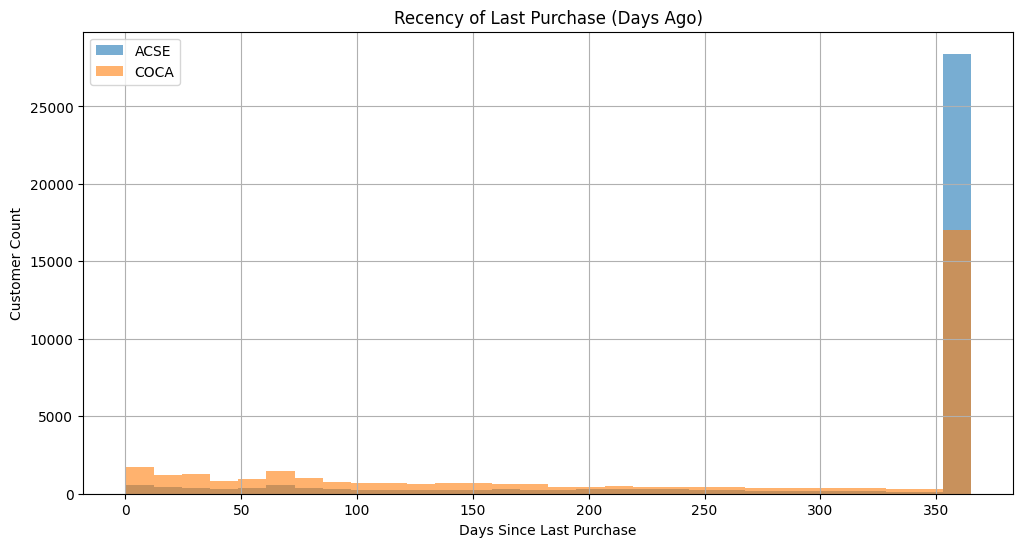

In [36]:
# Recency Analysis (Coke & ACSE)

# Last transaction dates
last_coke = csd_df[csd_df['prod_mfc_brand_cd'] == coke_brand].groupby('cust_id')['trans_dt'].max().rename('last_coke')
last_acse = csd_df[csd_df['prod_mfc_brand_cd'] == acse_brand].groupby('cust_id')['trans_dt'].max().rename('last_acse')

# Combine into a single DataFrame
recency_df = pd.concat([last_coke, last_acse], axis=1)
recency_df['coke_days_ago'] = (reference_date - recency_df['last_coke']).dt.days
recency_df['acse_days_ago'] = (reference_date - recency_df['last_acse']).dt.days
recency_df = recency_df.fillna(999)

plt.figure(figsize=(12, 6))
recency_df['acse_days_ago'].clip(upper=365).hist(bins=30, alpha=0.6, label='ACSE')
recency_df['coke_days_ago'].clip(upper=365).hist(bins=30, alpha=0.6, label='COCA')
plt.title("Recency of Last Purchase (Days Ago)")
plt.xlabel("Days Since Last Purchase")
plt.ylabel("Customer Count")
plt.legend()
plt.show()


In [34]:
# Define switching logic: bought Coke 6+ months ago, ACSE in last 3 months
recency_df['switched_to_acse'] = (
    (recency_df['coke_days_ago'] > 180) &
    (recency_df['acse_days_ago'] <= 90)
)

print(f"\n Potential Coke → ACSE switchers: {recency_df['switched_to_acse'].sum()}")



 Potential Coke → ACSE switchers: 2079


In [35]:
pure_competitor_buyers = competitor_customers - (coke_customers | acse_customers)
print(f"\n Pure competitor buyers (no Coke or ACSE): {len(pure_competitor_buyers)}")



 Pure competitor buyers (no Coke or ACSE): 16096


From this info we have some clear segments: recommend to pure competitor buyers and lapsed coke buyers who bought coke over 6 months ago with no recent ACSE. 

AVOID: recent ACSE (in last 3 months), current loyal coke buyers, and recent ACSE buyers but were previously coke.

In [ ]:
# Data Preparation

# Input: target brand or product
target_brand = 'COCA'

# Find all customers who have NOT purchased the target brand
target_customers = df[df['prod_mfc_brand_cd'] == target_brand]['cust_id'].unique().compute()

# Create a binary flag for whether each customer bought the target brand
df['bought_target'] = df['cust_id'].isin(set(target_customers)).astype(int)


AttributeError: 'numpy.ndarray' object has no attribute 'compute'

In [ ]:
# Feature Engineering
# Aggregated customer features
cust_features = df.groupby('cust_id').agg({
    'prod_category': 'nunique',
    'prod_mfc_brand_cd': 'nunique',
    'trans_id': 'nunique',
    'sales_amt': 'sum'
}).rename(columns={
    'prod_category': 'num_categories',
    'prod_mfc_brand_cd': 'num_brands',
    'trans_id': 'purchase_freq',
    'sales_amt': 'total_spent'
}).compute()

# Join with target label
cust_features['bought_target'] = cust_features.index.isin(target_customers).astype(int)


In [ ]:
# Train Recommender System
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = cust_features.drop(columns='bought_target')
y = cust_features['bought_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Logistic Regression w/ hyperparameter tuning
params = {'C': [0.1, 1, 10], 'penalty': ['l2']}
model = GridSearchCV(LogisticRegression(max_iter=500), params, cv=5)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


In [ ]:
# Make Recommendations

cust_features['recommend'] = model.predict(X)
final_output = cust_features[['recommend']].reset_index()


The system learns what types of customers tend to buy a specific brand (like Coca-Cola) by analyzing their spending behavior and similarities to other customers. It then uses a machine learning model to predict which other customers should be recommended that brand, even if they haven’t bought it yet. Output indicates 0 if we do not want to recommend to them, 1 indicates we should recommend. 

In [ ]:
import pandas as pd
# df but only with customers who made 5+ purchases in the last 6 mo
df = pd.read_csv("smaller_data_sample.csv")
products = pd.read_csv("products.csv")
# Merge product info into transactions
df = df.merge(products, on='prod_id', how='left')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

def recommend_for_brand(df, target_brand='COCA', k_neighbors=5, use_knn_features=True, use_logreg=True):
    """
    Generalizable recommender system:
    - Builds customer-level features
    - Trains logistic regression or k-NN
    - Returns DataFrame with recommendations

    Parameters:
    df (pd.DataFrame): Input transactional data with 'cust_id', 'prod_mfc_brand_cd', 'trans_id', 'sales_amt'
    target_brand (str): Brand to build recommendations for
    k_neighbors (int): Number of neighbors to use for k-NN features
    use_knn_features (bool): Whether to include k-NN similarity features
    use_logreg (bool): If True, use LogisticRegression; otherwise uses k-NN classifier

    Returns:
    pd.DataFrame: Customer-level DataFrame with recommendations
    """

    print(f"Building recommender for brand: {target_brand}")

    # Identify customers who bought the brand
    target_customers = df[df['prod_mfc_brand_cd'] == target_brand]['cust_id'].unique()

    # Step 1: Feature engineering
    cust_features = df.groupby('cust_id').agg({
        'prod_mfc_brand_cd': 'nunique',
        'prod_category': 'nunique',
        'trans_id': 'nunique',
        'sales_amt': 'sum'
    }).rename(columns={
        'prod_mfc_brand_cd': 'num_brands',
        'prod_category': 'num_categories',
        'trans_id': 'purchase_freq',
        'sales_amt': 'total_spent'
    })

    # Add binary label
    cust_features['bought_target'] = cust_features.index.isin(target_customers).astype(int)

    # Step 2: k-NN similarity features
    if use_knn_features:
        print("Computing k-NN similarity features...")
        cust_brand_matrix = df.pivot_table(index='cust_id', columns='prod_mfc_brand_cd',
                                           values='sales_amt', aggfunc='sum').fillna(0)

        knn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
        knn_model.fit(cust_brand_matrix)

        distances, _ = knn_model.kneighbors(cust_brand_matrix)
        avg_knn_dist = distances.mean(axis=1)

        # Join similarity features
        cust_features['avg_knn_dist'] = cust_features.index.map(dict(zip(cust_brand_matrix.index, avg_knn_dist)))

    # Step 3: Modeling
    X = cust_features.drop(columns='bought_target')
    y = cust_features['bought_target']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

    if use_logreg:
        print("Training Logistic Regression with hyperparameter tuning...")
        model = GridSearchCV(LogisticRegression(max_iter=500), param_grid={'C': [0.1, 1, 10]}, cv=5)
    else:
        print("Training k-NN classifier...")
        from sklearn.neighbors import KNeighborsClassifier
        model = KNeighborsClassifier(n_neighbors=k_neighbors)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\nModel performance on test set:")
    print(classification_report(y_test, y_pred))

    # Final prediction
    cust_features['recommend'] = model.predict(scaler.transform(X))
    return cust_features[['recommend']]


In [ ]:
# Make sure your input df has at least:
# 'cust_id', 'prod_mfc_brand_cd', 'prod_category', 'trans_id', 'sales_amt'
recommendations = recommend_for_brand(df, target_brand='COCA')
recommendations.head()

Building recommender for brand: COCA
Computing k-NN similarity features...
Training Logistic Regression with hyperparameter tuning...

Model performance on test set:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87     22866
           1       0.64      0.36      0.46      7652

    accuracy                           0.79     30518
   macro avg       0.73      0.65      0.67     30518
weighted avg       0.77      0.79      0.77     30518



,recommend
cust_id,
1000012004,0
1000018943,0
1000031877,0
1000066422,0
1000076877,0


The system learns what types of customers tend to buy a specific brand (like Coca-Cola) by analyzing their spending behavior and similarities to other customers. It then uses a machine learning model to predict which other customers should be recommended that brand, even if they haven’t bought it yet. Output indicates 0 if we do not want to recommend to them, 1 indicates we should recommend. 

In [59]:
import pandas as pd
# df but only with customers who made 5+ purchases in the last 6 mo
df = pd.read_csv("smaller_data_sample.csv")
products = pd.read_csv("products.csv")
# Merge product info into transactions
df = df.merge(products, on='prod_id', how='left')

In [60]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

def recommend_for_brand(df, target_brand='COCA', k_neighbors=5, use_knn_features=True, use_logreg=True):
    """
    Generalizable recommender system:
    - Computes product lift and importance
    - Builds customer-level features (including average lift)
    - Trains logistic regression or k-NN
    - Returns recommendations per customer

    Parameters:
    df (pd.DataFrame): Transactional data w/ 'cust_id', 'prod_id', 'prod_desc', 'prod_mfc_brand_cd', 'sales_amt', 'trans_id'
    products (pd.DataFrame): Product metadata with 'prod_id', 'prod_desc', 'prod_mfc_brand_cd'
    target_brand (str): Brand to train recommendation for
    k_neighbors (int): For k-NN
    use_knn_features (bool): Whether to include similarity features
    use_logreg (bool): Whether to use logistic regression (otherwise uses k-NN classifier)

    Returns:
    pd.DataFrame: Recommendations per customer
    """
    print(f"\n Building recommender for brand: {target_brand}")


    # -------------------------------
    # STEP 1: Product Lift Calculation
    # -------------------------------
    total_customers = df['cust_id'].nunique()
    coke_customers = df[df['prod_mfc_brand_cd'] == target_brand]['cust_id'].unique()
    coke_df = df[df['cust_id'].isin(coke_customers)]

    prod_global_freq = df.groupby('prod_desc')['cust_id'].nunique().rename("global_count")
    prod_coke_freq = coke_df.groupby('prod_desc')['cust_id'].nunique().rename("coke_count")

    lift_df = pd.concat([prod_coke_freq, prod_global_freq], axis=1).fillna(0)
    lift_df['P(B)'] = lift_df['global_count'] / total_customers
    lift_df['P(B|A)'] = lift_df['coke_count'] / len(coke_customers)
    lift_df['lift'] = lift_df['P(B|A)'] / lift_df['P(B)']
    lift_df['importance'] = lift_df['lift'] * np.log1p(lift_df['coke_count'])

    # Merge lift into df
    df = df.merge(lift_df[['lift']], on='prod_desc', how='left')
    df['lift'] = df['lift'].fillna(1.0)

    # -------------------------------
    # STEP 2: Label & Feature Engineering
    # -------------------------------
    target_customers = coke_customers
    cust_features = df.groupby('cust_id').agg({
        'prod_mfc_brand_cd': 'nunique',
        'prod_category': 'nunique',
        'trans_id': 'nunique',
        'sales_amt': 'sum'
    }).rename(columns={
        'prod_mfc_brand_cd': 'num_brands',
        'prod_category': 'num_categories',
        'trans_id': 'purchase_freq',
        'sales_amt': 'total_spent'
    })

    # Add binary target label
    cust_features['bought_target'] = cust_features.index.isin(target_customers).astype(int)

    # Add avg_lift feature
    avg_lift = df.groupby('cust_id')['lift'].mean().rename('avg_lift')
    cust_features = cust_features.join(avg_lift, how='left').fillna({'avg_lift': 1.0})

    # -------------------------------
    # STEP 3: Optional k-NN Features
    # -------------------------------
    if use_knn_features:
        print("🔍 Computing k-NN similarity features...")
        cust_brand_matrix = df.pivot_table(index='cust_id', columns='prod_mfc_brand_cd',
                                           values='sales_amt', aggfunc='sum').fillna(0)

        knn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
        knn_model.fit(cust_brand_matrix)
        distances, _ = knn_model.kneighbors(cust_brand_matrix)
        avg_knn_dist = distances.mean(axis=1)

        cust_features['avg_knn_dist'] = cust_features.index.map(
            dict(zip(cust_brand_matrix.index, avg_knn_dist))
        ).fillna(0.0)

    # -------------------------------
    # STEP 4: Model Training
    # -------------------------------
    X = cust_features.drop(columns='bought_target')
    y = cust_features['bought_target']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

    if use_logreg:
        print("Training Logistic Regression with GridSearch...")
        model = GridSearchCV(LogisticRegression(max_iter=500), param_grid={'C': [0.1, 1, 10]}, cv=5)
    else:
        print("Training k-NN classifier...")
        model = KNeighborsClassifier(n_neighbors=k_neighbors)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\nModel performance on test set:")
    print(classification_report(y_test, y_pred))

    # Final prediction
    cust_features['recommend'] = model.predict(scaler.transform(X))
    return cust_features[['recommend', 'avg_lift']]


In [61]:
# Make sure your input df has at least:
# 'cust_id', 'prod_mfc_brand_cd', 'prod_category', 'trans_id', 'sales_amt'
recommendations = recommend_for_brand(df, target_brand='COCA')
recommendations.head()


 Building recommender for brand: COCA
🔍 Computing k-NN similarity features...
Training Logistic Regression with GridSearch...

Model performance on test set:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     22866
           1       0.71      0.55      0.62      7652

    accuracy                           0.83     30518
   macro avg       0.79      0.74      0.76     30518
weighted avg       0.82      0.83      0.82     30518



,recommend,avg_lift
cust_id,,
1000012004,0,2.076272
1000018943,0,1.967162
1000031877,0,1.906884
1000066422,0,2.124640
1000076877,0,1.985926


# BASE Recommender System 1 (Logistic Regression + KNN + Revised logic to handle ACSE/Coke Recency) 

Goal: To predict which customers should be recommended a specific brand (e.g., Coca-Cola) based on their purchase history — while avoiding churned or loyal private-label customers.

### 1. Identify Brand Groups
- Filter the data to only include transactions from a target product subcategory (e.g., `'Carbonated Soft Drin'`).
- Group brands into:
  - Target brand (e.g., `'COCA'`)
  - Private label (e.g., `'ACSE'`)
  - All other brands (competitors)

### 2. Create a Target Variable
- Each customer is assigned a binary label:
  - `1` if they have ever purchased the target brand
  - `0` otherwise

This becomes the training label (`y`) for supervised learning.

### 3. Generate Customer-Level Features
For each customer, the following features are computed:
- `num_brands`: Number of distinct brands purchased
- `num_categories`: Number of distinct product categories purchased
- `purchase_freq`: Total number of transactions
- `total_spent`: Total amount spent

These features represent behavioral shopping patterns.

### 4. Add Brand Interaction Flags
Additional binary indicators are created:
- `recent_private_label`: Customer purchased the private-label brand in the last `acse_exclusion_days` (e.g., 90 days)
- `switched_to_private`: Customer stopped buying the target brand (> `churn_days` ago) but recently bought the private label
- `pure_competitor`: Customer has never bought the target or private label — only competitors

These flags capture churn and targeting eligibility.

### 5. Add k-NN Similarity Feature (Optional)
If enabled:
- A customer × brand matrix of spend amounts is built
- k-NN is applied to find similar shoppers
- `avg_knn_dist`: Average cosine distance to nearest neighbors is used as an additional feature

This adds collaborative filtering to the model.

### 6. Train Classification Model
- A classification model (e.g., logistic regression or k-NN) is trained using the above features
- The model predicts which customers are most likely to buy the target brand

### 7. Evaluate Model Performance
- Classification metrics (precision, recall, F1-score) are printed
- You can assess how well the model balances identifying actual buyers vs. avoiding false positives

### 8. Generate Recommendations
Each customer receives:
- `recommend`: 1 if they should be targeted, 0 if not
- `recent_private_label`: Flag for recent private-label purchases
- `switched_to_private`: Flag for churned target brand buyers
- `pure_competitor`: Flag for customers only buying competitors

### 9. Use Recommendations for Targeting
- Prioritize `recommend == 1` and `pure_competitor == 1` for conquesting
- Avoid `recent_private_label == 1` or `switched_to_private == 1` to prevent wasted targeting


In [44]:
import pandas as pd
# df but only with customers who made 5+ purchases in the last 6 mo
df = pd.read_csv("smaller_data_sample.csv")
products = pd.read_csv("products.csv")
# Merge product info into transactions
df = df.merge(products, on='prod_id', how='left')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

def recommend_for_brand(df,
                        target_brand,
                        target_subcategory='Carbonated Soft Drin',
                        private_label='ACSE',
                        k_neighbors=5,
                        use_knn_features=True,
                        use_logreg=True,
                        acse_exclusion_days=90,
                        churn_days=180):
    """
    Generalizable recommender system with churn & competitor logic.

    Parameters:
        df (pd.DataFrame): Transactions, must already contain merged product info.
        target_brand (str): Brand to build recommendations for.
        target_subcategory (str): Product subcategory to scope logic (e.g., 'Carbonated Soft Drin').
        private_label (str): Private label brand to exclude from targeting (e.g., 'ACSE').
        k_neighbors (int): For k-NN.
        use_knn_features (bool): Include cosine similarity signal.
        use_logreg (bool): Use logistic regression (True) or k-NN classifier (False).
        acse_exclusion_days (int): Cooldown window for recent private label buyers.
        churn_days (int): Churn definition for time since last target brand purchase.

    Returns:
        pd.DataFrame: Customer-level recommendation flags.
    """
    import numpy as np
    from datetime import timedelta
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
    from sklearn.metrics import classification_report
    from sklearn.preprocessing import StandardScaler

    # Safety check
    required_cols = ['cust_id', 'prod_id', 'trans_dt', 'prod_mfc_brand_cd', 'prod_subcategory']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in df: {missing}")

    print(f"\n Building recommender for brand: {target_brand}")

    df['trans_dt'] = pd.to_datetime(df['trans_dt'])
    reference_date = df['trans_dt'].max()

    # Focus on relevant subcategory
    subcat_df = df[df['prod_subcategory'] == target_subcategory].copy()

    # Define brand groups
    all_brands = subcat_df['prod_mfc_brand_cd'].unique()
    competitor_brands = [b for b in all_brands if b not in [target_brand, private_label]]

    # Recency calculations
    last_target = subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand].groupby('cust_id')['trans_dt'].max().rename('last_target')
    last_private = subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label].groupby('cust_id')['trans_dt'].max().rename('last_private')

    recency = pd.concat([last_target, last_private], axis=1)
    recency['days_since_target'] = (reference_date - recency['last_target']).dt.days
    recency['days_since_private'] = (reference_date - recency['last_private']).dt.days
    recency = recency.fillna(999)

    # Flag logic
    recency['recent_private_label'] = (recency['days_since_private'] <= acse_exclusion_days).astype(int)
    recency['switched_to_private'] = ((recency['days_since_target'] > churn_days) &
                                      (recency['days_since_private'] <= acse_exclusion_days)).astype(int)

    # Identify customer segments
    target_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand]['cust_id'])
    private_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label]['cust_id'])
    competitor_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'].isin(competitor_brands)]['cust_id'])

    pure_competitor = competitor_custs - (target_custs | private_custs)
    recency['pure_competitor'] = recency.index.isin(pure_competitor).astype(int)

    # ---------------------------------------------
    # Step 1: Feature Engineering + Label
    cust_features = df.groupby('cust_id').agg({
        'prod_mfc_brand_cd': 'nunique',
        'prod_category': 'nunique',
        'trans_id': 'nunique',
        'sales_amt': 'sum'
    }).rename(columns={
        'prod_mfc_brand_cd': 'num_brands',
        'prod_category': 'num_categories',
        'trans_id': 'purchase_freq',
        'sales_amt': 'total_spent'
    })

    cust_features['bought_target'] = cust_features.index.isin(target_custs).astype(int)
    cust_features = cust_features.join(recency[['recent_private_label', 'switched_to_private', 'pure_competitor']], how='left').fillna(0)

    # ---------------------------------------------
    # Step 2: k-NN Similarity Features
    if use_knn_features:
        print(" Adding k-NN similarity features...")
        cust_brand_matrix = df.pivot_table(index='cust_id', columns='prod_mfc_brand_cd',
                                           values='sales_amt', aggfunc='sum').fillna(0)

        knn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
        knn_model.fit(cust_brand_matrix)
        distances, _ = knn_model.kneighbors(cust_brand_matrix)
        avg_knn_dist = distances.mean(axis=1)

        cust_features['avg_knn_dist'] = cust_features.index.map(
            dict(zip(cust_brand_matrix.index, avg_knn_dist))
        ).fillna(0)

    # ---------------------------------------------
    # Step 3: Model Training
    X = cust_features.drop(columns='bought_target')
    y = cust_features['bought_target']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

    if use_logreg:
        print(" Training Logistic Regression...")
        model = GridSearchCV(LogisticRegression(max_iter=500), param_grid={'C': [0.1, 1, 10]}, cv=5)
    else:
        print(" Training k-NN classifier...")
        model = KNeighborsClassifier(n_neighbors=k_neighbors)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\n Model Performance:")
    print(classification_report(y_test, y_pred))

    # ---------------------------------------------
    # Step 4: Generate Recommendations
    cust_features['recommend'] = model.predict(scaler.transform(X))

    return cust_features[['recommend', 'recent_private_label', 'switched_to_private', 'pure_competitor']]



In [48]:
# Make sure your input df has at least:
# 'cust_id', 'prod_mfc_brand_cd', 'prod_category', 'trans_id', 'sales_amt'
recommendations = recommend_for_brand(df, target_brand='COCA')
recommendations.head()


 Building recommender for brand: COCA
🔍 Adding k-NN similarity features...
🤖 Training Logistic Regression...

📊 Model Performance:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88     23223
           1       0.66      0.34      0.45      7295

    accuracy                           0.80     30518
   macro avg       0.74      0.64      0.66     30518
weighted avg       0.78      0.80      0.77     30518



,recommend,recent_private_label,switched_to_private,pure_competitor
cust_id,,,,
1000012004,0,0.0,0.0,0.0
1000018943,0,0.0,0.0,0.0
1000031877,0,0.0,0.0,0.0
1000066422,0,0.0,0.0,0.0
1000076877,0,0.0,0.0,0.0


In [50]:
final_recommendations = recommendations[
    (recommendations['recommend'] == 1) &
    (recommendations['recent_private_label'] == 0) &
    (recommendations['switched_to_private'] == 0)
]
final_recommendations.head(10)

,recommend,recent_private_label,switched_to_private,pure_competitor
cust_id,,,,
1000241755,1,0.0,0.0,0.0
1000383951,1,0.0,0.0,0.0
1000404678,1,0.0,0.0,0.0
1000410283,1,0.0,0.0,0.0
1000636319,1,0.0,0.0,0.0
1000929691,1,0.0,0.0,0.0
1001138353,1,0.0,0.0,0.0
1001151438,1,0.0,0.0,0.0
1001431609,1,0.0,0.0,0.0


# BASE Recommender System 1.2 (Logistic Regression + KNN + Revised logic to handle generic items & ACSE/Coke Recency) 

## What This Recommender System Is Doing

### 1. Calculate Product Lift
- Identifies which products are purchased more frequently by **target brand buyers** (e.g., Coke) compared to everyone else
- For each product:
  - Computes how likely any customer is to buy it (`P(B)`)
  - Computes how likely a target brand buyer is to buy it (`P(B|A)`)
  - Calculates **lift = P(B|A) / P(B)**
  - Also calculates an `importance` score using log-weighted frequency

 This tells us which products are more strongly associated with the brand and avoids recommending overly generic items.

---

### 2. Add Lift to Transactions
- Merges the product-level lift scores back into the main transaction dataset
- Each customer’s transactions now include a `lift` score for the products they bought

---

### 3. Create Recency & Churn Flags
- Filters to the Carbonated Soft Drinks category (`prod_subcategory`)
- For each customer:
  - Finds the **most recent purchase date** of:
    - the **target brand** (e.g., Coke)
    - the **private label** brand (e.g., ACSE)
- From these dates, calculates:
  - `days_since_target`
  - `days_since_private`
- Creates churn-related flags:
  - `recent_private_label`: Bought ACSE in the last 90 days
  - `switched_to_private`: Stopped buying the target brand for 6+ months but recently bought ACSE
  - `pure_competitor`: Has never bought Coke or ACSE — only competitor brands

---

### 4. Engineer Customer-Level Features
- Groups the transaction data by customer and calculates:
  - `num_brands`: how many brands they buy from
  - `num_categories`: how many product categories they buy
  - `purchase_freq`: number of unique transactions
  - `total_spent`: total money spent
  - `avg_lift`: average lift score of the products they purchased
- Joins in the churn flags (`recent_private_label`, `switched_to_private`, `pure_competitor`)
- Creates the label `bought_target`:
  - `1` if the customer has ever purchased the target brand
  - `0` otherwise

---

### 5. Add k-NN Similarity Features
- Builds a matrix of `cust_id × brand` spend
- Applies k-NN to compute **cosine similarity to other customers**
- Adds `avg_knn_dist`: how far each customer is from their peers

This captures customer behavioral similarity across brands.

---

### 6. Train the Model
- Selects features (X) and the target label (y)
- Scales the features using StandardScaler
- Splits into train and test sets (stratified)
- Trains one of the following models:
  - ✅ Logistic Regression (default, with GridSearch for hyperparameter tuning)
  - 🔁 Or: k-Nearest Neighbors classifier

---

### 7. Evaluate Model Performance
- Prints out classification metrics: precision, recall, F1-score
- Evaluates how well the model identifies customers who are likely to buy the brand

---

### 8. Generate Customer Recommendations
- Predicts a binary recommendation (`recommend = 1` or `0`) for every customer
- Returns a DataFrame containing:
  - `recommend`: whether the brand should be recommended
  - `avg_lift`: signal of how strongly their purchased products are associated with the_


In [3]:
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

def recommend_for_brand(df,
                        target_brand,
                        target_subcategory='Carbonated Soft Drin',
                        private_label='ACSE',
                        k_neighbors=5,
                        use_knn_features=True,
                        use_logreg=True,
                        acse_exclusion_days=90,
                        churn_days=180):
    """
    Generalizable recommender system:
    - Computes product lift and churn indicators
    - Builds customer-level features (including lift and brand interaction flags)
    - Trains logistic regression or k-NN
    - Returns recommendations per customer
    """

    print(f"\n Building recommender for brand: {target_brand}")

    # Step 0: Basic checks
    required_cols = ['cust_id', 'prod_id', 'trans_dt', 'prod_mfc_brand_cd', 'prod_subcategory']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in df: {missing}")

    df['trans_dt'] = pd.to_datetime(df['trans_dt'])
    reference_date = df['trans_dt'].max()

    # -------------------------------
    # STEP 1: Product Lift Calculation
    # -------------------------------
    total_customers = df['cust_id'].nunique()
    target_customers = df[df['prod_mfc_brand_cd'] == target_brand]['cust_id'].unique()
    target_df = df[df['cust_id'].isin(target_customers)]

    prod_global_freq = df.groupby('prod_desc')['cust_id'].nunique().rename("global_count")
    prod_target_freq = target_df.groupby('prod_desc')['cust_id'].nunique().rename("target_count")

    lift_df = pd.concat([prod_target_freq, prod_global_freq], axis=1).fillna(0)
    lift_df['P(B)'] = lift_df['global_count'] / total_customers
    lift_df['P(B|A)'] = lift_df['target_count'] / len(target_customers)
    lift_df['lift'] = lift_df['P(B|A)'] / lift_df['P(B)']
    lift_df['importance'] = lift_df['lift'] * np.log1p(lift_df['target_count'])

    # Merge lift into df
    df = df.merge(lift_df[['lift']], on='prod_desc', how='left')
    df['lift'] = df['lift'].fillna(1.0)

    # -------------------------------
    # STEP 2: Churn & Brand Flags
    # -------------------------------
    subcat_df = df[df['prod_subcategory'] == target_subcategory].copy()
    all_brands = subcat_df['prod_mfc_brand_cd'].unique()
    competitor_brands = [b for b in all_brands if b not in [target_brand, private_label]]

    last_target = subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand].groupby('cust_id')['trans_dt'].max().rename('last_target')
    last_private = subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label].groupby('cust_id')['trans_dt'].max().rename('last_private')

    recency = pd.concat([last_target, last_private], axis=1)
    recency['days_since_target'] = (reference_date - recency['last_target']).dt.days
    recency['days_since_private'] = (reference_date - recency['last_private']).dt.days
    recency = recency.fillna(999)

    recency['recent_private_label'] = (recency['days_since_private'] <= acse_exclusion_days).astype(int)
    recency['switched_to_private'] = ((recency['days_since_target'] > churn_days) &
                                      (recency['days_since_private'] <= acse_exclusion_days)).astype(int)

    target_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand]['cust_id'])
    private_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label]['cust_id'])
    competitor_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'].isin(competitor_brands)]['cust_id'])

    pure_competitor = competitor_custs - (target_custs | private_custs)
    recency['pure_competitor'] = recency.index.isin(pure_competitor).astype(int)

    # -------------------------------
    # STEP 3: Feature Engineering
    # -------------------------------
    cust_features = df.groupby('cust_id').agg({
        'prod_mfc_brand_cd': 'nunique',
        'prod_category': 'nunique',
        'trans_id': 'nunique',
        'sales_amt': 'sum'
    }).rename(columns={
        'prod_mfc_brand_cd': 'num_brands',
        'prod_category': 'num_categories',
        'trans_id': 'purchase_freq',
        'sales_amt': 'total_spent'
    })

    cust_features['bought_target'] = cust_features.index.isin(target_customers).astype(int)

    avg_lift = df.groupby('cust_id')['lift'].mean().rename('avg_lift')
    cust_features = cust_features.join(avg_lift, how='left').fillna({'avg_lift': 1.0})

    cust_features = cust_features.join(recency[['recent_private_label', 'switched_to_private', 'pure_competitor']], how='left').fillna(0)

    # -------------------------------
    # STEP 4: Optional k-NN Similarity Features
    # -------------------------------
    if use_knn_features:
        print(" Adding k-NN similarity features...")
        cust_brand_matrix = df.pivot_table(index='cust_id', columns='prod_mfc_brand_cd',
                                           values='sales_amt', aggfunc='sum').fillna(0)

        knn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
        knn_model.fit(cust_brand_matrix)
        distances, _ = knn_model.kneighbors(cust_brand_matrix)
        avg_knn_dist = distances.mean(axis=1)

        cust_features['avg_knn_dist'] = cust_features.index.map(
            dict(zip(cust_brand_matrix.index, avg_knn_dist))
        ).fillna(0.0)

    # -------------------------------
    # STEP 5: Model Training
    # -------------------------------
    X = cust_features.drop(columns='bought_target')
    y = cust_features['bought_target']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

    if use_logreg:
        print(" Training Logistic Regression with GridSearch...")
        model = GridSearchCV(LogisticRegression(max_iter=500), param_grid={'C': [0.1, 1, 10]}, cv=5)
    else:
        print(" Training k-NN classifier...")
        model = KNeighborsClassifier(n_neighbors=k_neighbors)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(" Model Performance:")
    print(classification_report(y_test, y_pred))

    cust_features['recommend'] = model.predict(scaler.transform(X))

    return cust_features[['recommend', 'avg_lift', 'recent_private_label', 'switched_to_private', 'pure_competitor']]




In [64]:
df = pd.read_csv("smaller_data_sample.csv")
products = pd.read_csv("products.csv")
df = df.merge(products, on='prod_id', how='left')

In [65]:
recommendations = recommend_for_brand(df, target_brand='COCA')
print(recommendations.head())


 Building recommender for brand: COCA
 Adding k-NN similarity features...
 Training Logistic Regression with GridSearch...
 Model Performance:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     22866
           1       0.72      0.55      0.62      7652

    accuracy                           0.83     30518
   macro avg       0.79      0.74      0.76     30518
weighted avg       0.83      0.83      0.83     30518

            recommend  avg_lift  recent_private_label  switched_to_private  \
cust_id                                                                      
1000012004          0  2.076272                   0.0                  0.0   
1000018943          0  1.967162                   0.0                  0.0   
1000031877          0  1.906884                   0.0                  0.0   
1000066422          0  2.124640                   0.0                  0.0   
1000076877          0  1.985926                   0.0        

In [66]:
final_recommendations = recommendations[
    (recommendations['recommend'] == 1) &
    (recommendations['recent_private_label'] == 0) &
    (recommendations['switched_to_private'] == 0)
]
final_recommendations.head(10)

,recommend,avg_lift,recent_private_label,switched_to_private,pure_competitor
cust_id,,,,,
1000231427,1,2.204892,0.0,0.0,0.0
1000241755,1,2.126984,0.0,0.0,0.0
1000337998,1,2.179718,0.0,0.0,0.0
1000383951,1,2.151513,0.0,0.0,0.0
1000404678,1,2.121161,0.0,0.0,0.0
1000410283,1,2.132051,0.0,0.0,0.0
1000512080,1,2.143371,0.0,0.0,0.0
1000636319,1,2.084776,0.0,0.0,0.0
1000825070,1,2.214688,0.0,0.0,0.0


Class 0 = "Don’t recommend"
- Precision: 0.86 → 86% of predicted "not recommend" were correct
- Recall: 0.93 → 93% of true non-buyers were correctly identified
- F1-score: 0.89 → High reliability for rejecting customers

Class 1 = "Recommend"
- Precision: 0.72 → 72% of predicted "recommend" customers were actual buyers
- Recall: 0.55 → The model only caught 55% of all actual buyers
- F1-score: 0.62 → Decent, but room to improve on catching more potential buyers

Overall accuracy: 83%

The model leans toward conservative recommendations (it avoids false positives)

The model is prioritizing precision over recall — recommending only when it’s more confident

# BASE Recommender System 1.3 (Previous COMBINED + Probability of Purchasing Target Product)

In [2]:
import pandas as pd
df = pd.read_csv("smaller_data_sample.csv")
products = pd.read_csv("products.csv")
df = df.merge(products, on='prod_id', how='left')

In [3]:
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


def recommend_for_brand(df,
                        target_brand,
                        target_subcategory='Carbonated Soft Drin',
                        private_label='ACSE',
                        k_neighbors=5,
                        use_knn_features=True,
                        use_logreg=True,
                        acse_exclusion_days=90,
                        churn_days=180):
    """
    Generalizable recommender system:
    - Computes product lift and churn indicators
    - Builds customer-level features (including lift and brand interaction flags)
    - Trains logistic regression or k-NN
    - Returns recommendations per customer including probability estimates
    """

    print(f"\n Building recommender for brand: {target_brand}")

    required_cols = ['cust_id', 'prod_id', 'trans_dt', 'prod_mfc_brand_cd', 'prod_subcategory']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in df: {missing}")

    df['trans_dt'] = pd.to_datetime(df['trans_dt'])
    reference_date = df['trans_dt'].max()

    # STEP 1: Product Lift Calculation
    total_customers = df['cust_id'].nunique()
    target_customers = df[df['prod_mfc_brand_cd'] == target_brand]['cust_id'].unique()
    target_df = df[df['cust_id'].isin(target_customers)]

    prod_global_freq = df.groupby('prod_desc')['cust_id'].nunique().rename("global_count")
    prod_target_freq = target_df.groupby('prod_desc')['cust_id'].nunique().rename("target_count")

    lift_df = pd.concat([prod_target_freq, prod_global_freq], axis=1).fillna(0)
    lift_df['P(B)'] = lift_df['global_count'] / total_customers
    lift_df['P(B|A)'] = lift_df['target_count'] / len(target_customers)
    lift_df['lift'] = lift_df['P(B|A)'] / lift_df['P(B)']
    lift_df['importance'] = lift_df['lift'] * np.log1p(lift_df['target_count'])

    df = df.merge(lift_df[['lift']], on='prod_desc', how='left')
    df['lift'] = df['lift'].fillna(1.0)

    # STEP 2: Churn & Brand Flags (subcategory-based exclusion)
    subcat_df = df[df['prod_subcategory'] == target_subcategory].copy()
    all_brands = subcat_df['prod_mfc_brand_cd'].unique()
    competitor_brands = [b for b in all_brands if b not in [target_brand, private_label]]

    last_target = subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand].groupby('cust_id')['trans_dt'].max().rename('last_target')
    last_private = subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label].groupby('cust_id')['trans_dt'].max().rename('last_private')

    recency = pd.concat([last_target, last_private], axis=1)
    recency['days_since_target'] = (reference_date - recency['last_target']).dt.days
    recency['days_since_private'] = (reference_date - recency['last_private']).dt.days
    recency = recency.fillna(999)

    recency['recent_private_label'] = (recency['days_since_private'] <= acse_exclusion_days).astype(int)
    recency['switched_to_private'] = ((recency['days_since_target'] > churn_days) &
                                      (recency['days_since_private'] <= acse_exclusion_days)).astype(int)

    target_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand]['cust_id'])
    private_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label]['cust_id'])
    competitor_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'].isin(competitor_brands)]['cust_id'])
    pure_competitor = competitor_custs - (target_custs | private_custs)
    recency['pure_competitor'] = recency.index.isin(pure_competitor).astype(int)

    # STEP 3: Feature Engineering
    cust_features = df.groupby('cust_id').agg({
        'prod_mfc_brand_cd': 'nunique',
        'prod_category': 'nunique',
        'trans_id': 'nunique',
        'sales_amt': 'sum'
    }).rename(columns={
        'prod_mfc_brand_cd': 'num_brands',
        'prod_category': 'num_categories',
        'trans_id': 'purchase_freq',
        'sales_amt': 'total_spent'
    })

    cust_features['bought_target'] = cust_features.index.isin(target_customers).astype(int)
    avg_lift = df.groupby('cust_id')['lift'].mean().rename('avg_lift')
    cust_features = cust_features.join(avg_lift, how='left').fillna({'avg_lift': 1.0})
    cust_features = cust_features.join(recency[['recent_private_label', 'switched_to_private', 'pure_competitor']], how='left').fillna(0)

    # STEP 4: Optional k-NN Similarity Features
    if use_knn_features:
        print(" Adding k-NN similarity features...")
        cust_brand_matrix = df.pivot_table(index='cust_id', columns='prod_mfc_brand_cd',
                                           values='sales_amt', aggfunc='sum').fillna(0)
        knn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
        knn_model.fit(cust_brand_matrix)
        distances, _ = knn_model.kneighbors(cust_brand_matrix)
        avg_knn_dist = distances.mean(axis=1)
        cust_features['avg_knn_dist'] = cust_features.index.map(dict(zip(cust_brand_matrix.index, avg_knn_dist))).fillna(0.0)

    # STEP 5: Model Training
    X = cust_features.drop(columns='bought_target')
    y = cust_features['bought_target']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

    if use_logreg:
        print(" Training Logistic Regression with GridSearch...")
        model = GridSearchCV(LogisticRegression(max_iter=500), param_grid={'C': [0.1, 1, 10]}, cv=5)
    else:
        print(" Training k-NN classifier...")
        model = KNeighborsClassifier(n_neighbors=k_neighbors)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(" Model Performance:")
    print(classification_report(y_test, y_pred))

    cust_features['recommend'] = model.predict(scaler.transform(X))

    if hasattr(model, 'predict_proba'):
        cust_features['probability'] = model.predict_proba(scaler.transform(X))[:, 1]
    else:
        cust_features['probability'] = np.nan

    return cust_features[['recommend', 'probability', 'avg_lift', 'recent_private_label', 'switched_to_private', 'pure_competitor']]


In [4]:
recommendations = recommend_for_brand(df, target_brand='COCA')
print(recommendations.head())


 Building recommender for brand: COCA
 Adding k-NN similarity features...
 Training Logistic Regression with GridSearch...
 Model Performance:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     22866
           1       0.72      0.55      0.62      7652

    accuracy                           0.83     30518
   macro avg       0.79      0.74      0.76     30518
weighted avg       0.83      0.83      0.83     30518

            recommend  probability  avg_lift  recent_private_label  \
cust_id                                                              
1000012004          0     0.187955  2.076272                   0.0   
1000018943          0     0.198796  1.967162                   0.0   
1000031877          0     0.083591  1.906884                   0.0   
1000066422          0     0.391718  2.124640                   0.0   
1000076877          0     0.082715  1.985926                   0.0   

            switched_to_private  pure_

In [5]:
final_recommendations = recommendations[
    (recommendations['recommend'] == 1) &
    (recommendations['recent_private_label'] == 0) &
    (recommendations['switched_to_private'] == 0)
]
final_recommendations.head(10)

,recommend,probability,avg_lift,recent_private_label,switched_to_private,pure_competitor
cust_id,,,,,,
1000231427,1,0.753409,2.204892,0.0,0.0,0.0
1000241755,1,0.680002,2.126984,0.0,0.0,0.0
1000337998,1,0.672107,2.179718,0.0,0.0,0.0
1000383951,1,0.922068,2.151513,0.0,0.0,0.0
1000404678,1,0.590631,2.121161,0.0,0.0,0.0
1000410283,1,0.844423,2.132051,0.0,0.0,0.0
1000512080,1,0.607228,2.143371,0.0,0.0,0.0
1000636319,1,0.687942,2.084776,0.0,0.0,0.0
1000825070,1,0.632841,2.214688,0.0,0.0,0.0


# BASE Recommender 1.4 (1.3 + KNN Tuning Loop)

In [9]:
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler


def recommend_for_brand(df,
                        target_brand,
                        target_subcategory='Carbonated Soft Drin',
                        private_label='ACSE',
                        k_neighbors=5,
                        use_knn_features=True,
                        use_logreg=True,
                        acse_exclusion_days=90,
                        churn_days=180,
                        tune_knn_feature=False,
                        k_range=range(3, 15)):
    """
    Generalizable recommender system:
    - Computes product lift and churn indicators
    - Builds customer-level features (including lift and brand interaction flags)
    - Trains logistic regression or k-NN
    - Tunes k-NN similarity feature if desired
    - Returns recommendations per customer including probability estimates
    """

    print(f"\n Building recommender for brand: {target_brand}")

    required_cols = ['cust_id', 'prod_id', 'trans_dt', 'prod_mfc_brand_cd', 'prod_subcategory']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in df: {missing}")

    df['trans_dt'] = pd.to_datetime(df['trans_dt'])
    reference_date = df['trans_dt'].max()

    # STEP 1: Product Lift Calculation
    total_customers = df['cust_id'].nunique()
    target_customers = df[df['prod_mfc_brand_cd'] == target_brand]['cust_id'].unique()
    target_df = df[df['cust_id'].isin(target_customers)]

    prod_global_freq = df.groupby('prod_desc')['cust_id'].nunique().rename("global_count")
    prod_target_freq = target_df.groupby('prod_desc')['cust_id'].nunique().rename("target_count")

    lift_df = pd.concat([prod_target_freq, prod_global_freq], axis=1).fillna(0)
    lift_df['P(B)'] = lift_df['global_count'] / total_customers
    lift_df['P(B|A)'] = lift_df['target_count'] / len(target_customers)
    lift_df['lift'] = lift_df['P(B|A)'] / lift_df['P(B)']
    lift_df['importance'] = lift_df['lift'] * np.log1p(lift_df['target_count'])

    df = df.merge(lift_df[['lift']], on='prod_desc', how='left')
    df['lift'] = df['lift'].fillna(1.0)

    # STEP 2: Churn & Brand Flags (subcategory-based exclusion)
    subcat_df = df[df['prod_subcategory'] == target_subcategory].copy()
    all_brands = subcat_df['prod_mfc_brand_cd'].unique()
    competitor_brands = [b for b in all_brands if b not in [target_brand, private_label]]

    last_target = subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand].groupby('cust_id')['trans_dt'].max().rename('last_target')
    last_private = subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label].groupby('cust_id')['trans_dt'].max().rename('last_private')

    recency = pd.concat([last_target, last_private], axis=1)
    recency['days_since_target'] = (reference_date - recency['last_target']).dt.days
    recency['days_since_private'] = (reference_date - recency['last_private']).dt.days
    recency = recency.fillna(999)

    recency['recent_private_label'] = (recency['days_since_private'] <= acse_exclusion_days).astype(int)
    recency['switched_to_private'] = ((recency['days_since_target'] > churn_days) &
                                      (recency['days_since_private'] <= acse_exclusion_days)).astype(int)

    target_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand]['cust_id'])
    private_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label]['cust_id'])
    competitor_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'].isin(competitor_brands)]['cust_id'])
    pure_competitor = competitor_custs - (target_custs | private_custs)
    recency['pure_competitor'] = recency.index.isin(pure_competitor).astype(int)

    # STEP 3: Feature Engineering
    cust_features = df.groupby('cust_id').agg({
        'prod_mfc_brand_cd': 'nunique',
        'prod_category': 'nunique',
        'trans_id': 'nunique',
        'sales_amt': 'sum'
    }).rename(columns={
        'prod_mfc_brand_cd': 'num_brands',
        'prod_category': 'num_categories',
        'trans_id': 'purchase_freq',
        'sales_amt': 'total_spent'
    })

    cust_features['bought_target'] = cust_features.index.isin(target_customers).astype(int)
    y = cust_features['bought_target']

    avg_lift = df.groupby('cust_id')['lift'].mean().rename('avg_lift')
    cust_features = cust_features.join(avg_lift, how='left').fillna({'avg_lift': 1.0})
    cust_features = cust_features.join(recency[['recent_private_label', 'switched_to_private', 'pure_competitor']], how='left').fillna(0)

    # STEP 4: Optional k-NN Similarity Features
    if use_knn_features:
        print(" Adding k-NN similarity features...")
        cust_brand_matrix = df.pivot_table(index='cust_id', columns='prod_mfc_brand_cd',
                                           values='sales_amt', aggfunc='sum').fillna(0)

        best_k = k_neighbors
        if tune_knn_feature:
            print(" Tuning best k for k-NN similarity feature...")
            best_score = -np.inf
            for k in k_range:
                knn_model = NearestNeighbors(n_neighbors=k, metric='cosine')
                knn_model.fit(cust_brand_matrix)
                distances, _ = knn_model.kneighbors(cust_brand_matrix)
                avg_knn_dist = distances.mean(axis=1)
                cust_features_temp = cust_features.copy()
                cust_features_temp['avg_knn_dist'] = cust_features_temp.index.map(
                    dict(zip(cust_brand_matrix.index, avg_knn_dist))
                ).fillna(0.0)

                X_temp = cust_features_temp.drop(columns='bought_target')
                X_temp_scaled = StandardScaler().fit_transform(X_temp)
                score = LogisticRegression(max_iter=200).fit(X_temp_scaled, y).score(X_temp_scaled, y)

                if score > best_score:
                    best_score = score
                    best_k = k

            print(f" Best k for similarity feature: {best_k} (Pseudo accuracy: {best_score:.4f})")

        knn_model = NearestNeighbors(n_neighbors=best_k, metric='cosine')
        knn_model.fit(cust_brand_matrix)
        distances, _ = knn_model.kneighbors(cust_brand_matrix)
        avg_knn_dist = distances.mean(axis=1)
        cust_features['avg_knn_dist'] = cust_features.index.map(
            dict(zip(cust_brand_matrix.index, avg_knn_dist))
        ).fillna(0.0)

    # STEP 5: Model Training
    X = cust_features.drop(columns='bought_target')

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

    if use_logreg:
        print(" Training Logistic Regression with GridSearch...")
        model = GridSearchCV(LogisticRegression(max_iter=500), param_grid={'C': [0.1, 1, 10]}, cv=5)
    else:
        print(" Training k-NN classifier...")
        model = KNeighborsClassifier(n_neighbors=k_neighbors)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(" Model Performance:")
    print(classification_report(y_test, y_pred))

    cust_features['recommend'] = model.predict(scaler.transform(X))

    if hasattr(model, 'predict_proba'):
        cust_features['probability'] = model.predict_proba(scaler.transform(X))[:, 1]
    else:
        cust_features['probability'] = np.nan

    return cust_features[['recommend', 'probability', 'avg_lift', 'recent_private_label', 'switched_to_private', 'pure_competitor']]


In [10]:
recommendations = recommend_for_brand(
    df,
    target_brand='COCA',
    use_logreg=True,
    use_knn_features=True,
    tune_knn_feature=True,
    k_range=range(3, 12)
)



 Building recommender for brand: COCA
 Adding k-NN similarity features...
 Tuning best k for k-NN similarity feature...
 Best k for similarity feature: 11 (Pseudo accuracy: 0.8333)
 Training Logistic Regression with GridSearch...
 Model Performance:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     22866
           1       0.72      0.55      0.63      7652

    accuracy                           0.83     30518
   macro avg       0.79      0.74      0.76     30518
weighted avg       0.83      0.83      0.83     30518



In [11]:
final_recommendations = recommendations[
    (recommendations['recommend'] == 1) &
    (recommendations['recent_private_label'] == 0) &
    (recommendations['switched_to_private'] == 0)
]
final_recommendations.head(10)

,recommend,probability,avg_lift,recent_private_label,switched_to_private,pure_competitor
cust_id,,,,,,
1000231427,1,0.754651,2.204892,0.0,0.0,0.0
1000241755,1,0.681656,2.126984,0.0,0.0,0.0
1000337998,1,0.673324,2.179718,0.0,0.0,0.0
1000383951,1,0.922936,2.151513,0.0,0.0,0.0
1000404678,1,0.593332,2.121161,0.0,0.0,0.0
1000410283,1,0.844152,2.132051,0.0,0.0,0.0
1000512080,1,0.608222,2.143371,0.0,0.0,0.0
1000636319,1,0.688030,2.084776,0.0,0.0,0.0
1000825070,1,0.632493,2.214688,0.0,0.0,0.0


In [14]:
recommendations.to_csv("recommendations1.csv", index=True)
print("Recommendations saved successfully!")

Recommendations saved successfully!


In [15]:
final_recommendations.to_csv("recommendations1_final.csv", index=True)
print("Recommendations saved successfully!")

Recommendations saved successfully!


In [16]:
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


def recommend_for_brand(df,
                        target_brand,
                        target_subcategory='Carbonated Soft Drin',
                        private_label='ACSE',
                        k_neighbors=11,
                        use_knn_features=True,
                        use_logreg=True,
                        acse_exclusion_days=90,
                        churn_days=180):
    """
    Generalizable recommender system:
    - Computes product lift and churn indicators
    - Builds customer-level features (including lift and brand interaction flags)
    - Trains logistic regression or k-NN
    - Returns customer-level product recommendations for all products in the target brand
    """

    print(f"\n Building recommender for brand: {target_brand}")

    required_cols = ['cust_id', 'prod_id', 'trans_dt', 'prod_mfc_brand_cd', 'prod_subcategory']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in df: {missing}")

    df['trans_dt'] = pd.to_datetime(df['trans_dt'])
    reference_date = df['trans_dt'].max()

    # STEP 1: Product Lift Calculation
    total_customers = df['cust_id'].nunique()
    target_customers = df[df['prod_mfc_brand_cd'] == target_brand]['cust_id'].unique()
    target_df = df[df['cust_id'].isin(target_customers)]

    prod_global_freq = df.groupby('prod_desc')['cust_id'].nunique().rename("global_count")
    prod_target_freq = target_df.groupby('prod_desc')['cust_id'].nunique().rename("target_count")

    lift_df = pd.concat([prod_target_freq, prod_global_freq], axis=1).fillna(0)
    lift_df['P(B)'] = lift_df['global_count'] / total_customers
    lift_df['P(B|A)'] = lift_df['target_count'] / len(target_customers)
    lift_df['lift'] = lift_df['P(B|A)'] / lift_df['P(B)']
    lift_df['importance'] = lift_df['lift'] * np.log1p(lift_df['target_count'])

    df = df.merge(lift_df[['lift']], on='prod_desc', how='left')
    df['lift'] = df['lift'].fillna(1.0)

    # STEP 2: Churn & Brand Flags
    subcat_df = df[df['prod_subcategory'] == target_subcategory].copy()
    all_brands = subcat_df['prod_mfc_brand_cd'].unique()
    competitor_brands = [b for b in all_brands if b not in [target_brand, private_label]]

    last_target = subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand].groupby('cust_id')['trans_dt'].max().rename('last_target')
    last_private = subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label].groupby('cust_id')['trans_dt'].max().rename('last_private')

    recency = pd.concat([last_target, last_private], axis=1)
    recency['days_since_target'] = (reference_date - recency['last_target']).dt.days
    recency['days_since_private'] = (reference_date - recency['last_private']).dt.days
    recency = recency.fillna(999)

    recency['recent_private_label'] = (recency['days_since_private'] <= acse_exclusion_days).astype(int)
    recency['switched_to_private'] = ((recency['days_since_target'] > churn_days) &
                                      (recency['days_since_private'] <= acse_exclusion_days)).astype(int)

    target_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand]['cust_id'])
    private_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label]['cust_id'])
    competitor_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'].isin(competitor_brands)]['cust_id'])
    pure_competitor = competitor_custs - (target_custs | private_custs)
    recency['pure_competitor'] = recency.index.isin(pure_competitor).astype(int)

    # STEP 3: Feature Engineering
    cust_features = df.groupby('cust_id').agg({
        'prod_mfc_brand_cd': 'nunique',
        'prod_category': 'nunique',
        'trans_id': 'nunique',
        'sales_amt': 'sum'
    }).rename(columns={
        'prod_mfc_brand_cd': 'num_brands',
        'prod_category': 'num_categories',
        'trans_id': 'purchase_freq',
        'sales_amt': 'total_spent'
    })

    cust_features['bought_target'] = cust_features.index.isin(target_customers).astype(int)
    avg_lift = df.groupby('cust_id')['lift'].mean().rename('avg_lift')
    cust_features = cust_features.join(avg_lift, how='left').fillna({'avg_lift': 1.0})
    cust_features = cust_features.join(recency[['recent_private_label', 'switched_to_private', 'pure_competitor']], how='left').fillna(0)

    # STEP 4: k-NN Similarity Features
    if use_knn_features:
        print(" Adding k-NN similarity features...")
        cust_brand_matrix = df.pivot_table(index='cust_id', columns='prod_mfc_brand_cd',
                                           values='sales_amt', aggfunc='sum').fillna(0)
        knn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
        knn_model.fit(cust_brand_matrix)
        distances, _ = knn_model.kneighbors(cust_brand_matrix)
        avg_knn_dist = distances.mean(axis=1)
        cust_features['avg_knn_dist'] = cust_features.index.map(dict(zip(cust_brand_matrix.index, avg_knn_dist))).fillna(0.0)

    # STEP 5: Model Training
    X = cust_features.drop(columns='bought_target')
    y = cust_features['bought_target']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

    if use_logreg:
        print(" Training Logistic Regression with GridSearch...")
        model = GridSearchCV(LogisticRegression(max_iter=500), param_grid={'C': [0.1, 1, 10]}, cv=5)
    else:
        print(" Training k-NN classifier...")
        model = KNeighborsClassifier(n_neighbors=k_neighbors)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(" Model Performance:")
    print(classification_report(y_test, y_pred))

    cust_features['recommend'] = model.predict(scaler.transform(X))

    if hasattr(model, 'predict_proba'):
        cust_features['probability'] = model.predict_proba(scaler.transform(X))[:, 1]
    else:
        cust_features['probability'] = np.nan

    # STEP 6: Recommend each product from target brand with the same probability
    product_ids = df[df['prod_mfc_brand_cd'] == target_brand][['prod_id', 'prod_desc']].drop_duplicates()
    results = cust_features.reset_index()[['cust_id', 'recommend', 'probability', 'recent_private_label', 'switched_to_private']]
    results = results.merge(product_ids.assign(key=1), how='cross')  # Cartesian join
    results['probability_of_product'] = results['probability']  # Apply same probability to each product

    # Filter out ACSE recent buyers or switchers
    results = results[(results['recent_private_label'] == 0) & (results['switched_to_private'] == 0)]

    return results[['cust_id', 'recommend', 'probability_of_product', 'prod_id', 'prod_desc']]


In [ ]:
import pandas as pd
df = pd.read_csv("smaller_data_sample.csv")
products = pd.read_csv("products.csv")
df = df.merge(products, on='prod_id', how='left')

In [17]:
recommendations = recommend_for_brand(df, target_brand='COCA')
recommendations.head(10)


 Building recommender for brand: COCA
 Adding k-NN similarity features...
 Training Logistic Regression with GridSearch...
 Model Performance:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     22866
           1       0.72      0.55      0.63      7652

    accuracy                           0.83     30518
   macro avg       0.79      0.74      0.76     30518
weighted avg       0.83      0.83      0.83     30518



,cust_id,recommend,probability_of_product,prod_id,prod_desc
0,1000012004,0,0.188808,20354288002,COCA-COLA CLASSIC
1,1000012004,0,0.188808,21201180,COCA-COLA STEVIA
2,1000012004,0,0.188808,20354288001,COCA- COLA ZERO
3,1000012004,0,0.188808,20048388001,COKE CLASSIC GLASS
4,1000012004,0,0.188808,20316026002,COCA-COLA
5,1000012004,0,0.188808,21185429,COCA-COLA BC RASPBERRY
6,1000012004,0,0.188808,20316026005,COCA-COLA ZERO
7,1000012004,0,0.188808,20827666,DIET COKE 500ML BOTTLE
8,1000012004,0,0.188808,20318694001,Coca-Cola Zero
9,1000012004,0,0.188808,20045130,GLACEAU SMARTWATER


In [ ]:
recommendations.to_csv("recommendations.csv", index=True)
print("Recommendations saved successfully!")

In [ ]:
import pandas as pd
df = pd.read_csv("smaller_data_sample.csv")
products = pd.read_csv("products.csv")
df = df.merge(products, on='prod_id', how='left')

# BASE Recommender System 4 (KNN + Naive Bayes)

In [67]:
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def recommend_for_brand_nb(df,
                           target_brand,
                           target_subcategory='Carbonated Soft Drin',
                           private_label='ACSE',
                           k_neighbors=5,
                           use_knn_features=True,
                           acse_exclusion_days=90,
                           churn_days=180):
    """
    Generalizable recommender system using Naive Bayes:
    - Computes product lift and churn indicators
    - Builds customer-level features (including lift and brand interaction flags)
    - Trains Naive Bayes classifier
    - Returns recommendations per customer
    """

    print(f"\n Building recommender for brand (Naive Bayes): {target_brand}")

    # Step 0: Basic checks
    required_cols = ['cust_id', 'prod_id', 'trans_dt', 'prod_mfc_brand_cd', 'prod_subcategory']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in df: {missing}")

    df['trans_dt'] = pd.to_datetime(df['trans_dt'])
    reference_date = df['trans_dt'].max()

    # STEP 1: Product Lift Calculation
    total_customers = df['cust_id'].nunique()
    target_customers = df[df['prod_mfc_brand_cd'] == target_brand]['cust_id'].unique()
    target_df = df[df['cust_id'].isin(target_customers)]

    prod_global_freq = df.groupby('prod_desc')['cust_id'].nunique().rename("global_count")
    prod_target_freq = target_df.groupby('prod_desc')['cust_id'].nunique().rename("target_count")

    lift_df = pd.concat([prod_target_freq, prod_global_freq], axis=1).fillna(0)
    lift_df['P(B)'] = lift_df['global_count'] / total_customers
    lift_df['P(B|A)'] = lift_df['target_count'] / len(target_customers)
    lift_df['lift'] = lift_df['P(B|A)'] / lift_df['P(B)']
    lift_df['importance'] = lift_df['lift'] * np.log1p(lift_df['target_count'])

    df = df.merge(lift_df[['lift']], on='prod_desc', how='left')
    df['lift'] = df['lift'].fillna(1.0)

    # STEP 2: Churn & Brand Flags
    subcat_df = df[df['prod_subcategory'] == target_subcategory].copy()
    all_brands = subcat_df['prod_mfc_brand_cd'].unique()
    competitor_brands = [b for b in all_brands if b not in [target_brand, private_label]]

    last_target = subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand].groupby('cust_id')['trans_dt'].max().rename('last_target')
    last_private = subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label].groupby('cust_id')['trans_dt'].max().rename('last_private')

    recency = pd.concat([last_target, last_private], axis=1)
    recency['days_since_target'] = (reference_date - recency['last_target']).dt.days
    recency['days_since_private'] = (reference_date - recency['last_private']).dt.days
    recency = recency.fillna(999)

    recency['recent_private_label'] = (recency['days_since_private'] <= acse_exclusion_days).astype(int)
    recency['switched_to_private'] = ((recency['days_since_target'] > churn_days) &
                                      (recency['days_since_private'] <= acse_exclusion_days)).astype(int)

    target_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand]['cust_id'])
    private_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label]['cust_id'])
    competitor_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'].isin(competitor_brands)]['cust_id'])

    pure_competitor = competitor_custs - (target_custs | private_custs)
    recency['pure_competitor'] = recency.index.isin(pure_competitor).astype(int)

    # STEP 3: Feature Engineering
    cust_features = df.groupby('cust_id').agg({
        'prod_mfc_brand_cd': 'nunique',
        'prod_category': 'nunique',
        'trans_id': 'nunique',
        'sales_amt': 'sum'
    }).rename(columns={
        'prod_mfc_brand_cd': 'num_brands',
        'prod_category': 'num_categories',
        'trans_id': 'purchase_freq',
        'sales_amt': 'total_spent'
    })

    cust_features['bought_target'] = cust_features.index.isin(target_customers).astype(int)
    avg_lift = df.groupby('cust_id')['lift'].mean().rename('avg_lift')
    cust_features = cust_features.join(avg_lift, how='left').fillna({'avg_lift': 1.0})
    cust_features = cust_features.join(recency[['recent_private_label', 'switched_to_private', 'pure_competitor']], how='left').fillna(0)

    # STEP 4: Optional k-NN Similarity Features
    if use_knn_features:
        print(" Adding k-NN similarity features...")
        cust_brand_matrix = df.pivot_table(index='cust_id', columns='prod_mfc_brand_cd',
                                           values='sales_amt', aggfunc='sum').fillna(0)
        knn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='cosine')
        knn_model.fit(cust_brand_matrix)
        distances, _ = knn_model.kneighbors(cust_brand_matrix)
        avg_knn_dist = distances.mean(axis=1)
        cust_features['avg_knn_dist'] = cust_features.index.map(dict(zip(cust_brand_matrix.index, avg_knn_dist))).fillna(0.0)

    # STEP 5: Model Training
    X = cust_features.drop(columns='bought_target')
    y = cust_features['bought_target']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

    print(" Training Naive Bayes...")
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(" Model Performance:")
    print(classification_report(y_test, y_pred))

    cust_features['recommend'] = model.predict(scaler.transform(X))
    return cust_features[['recommend', 'avg_lift', 'recent_private_label', 'switched_to_private', 'pure_competitor']]


In [68]:
recommendations = recommend_for_brand_nb(df, target_brand='COCA')
recommendations.head()


 Building recommender for brand (Naive Bayes): COCA
 Adding k-NN similarity features...
 Training Naive Bayes...
 Model Performance:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     22866
           1       0.62      0.40      0.48      7652

    accuracy                           0.79     30518
   macro avg       0.72      0.66      0.68     30518
weighted avg       0.77      0.79      0.77     30518



,recommend,avg_lift,recent_private_label,switched_to_private,pure_competitor
cust_id,,,,,
1000012004,0,2.076272,0.0,0.0,0.0
1000018943,0,1.967162,0.0,0.0,0.0
1000031877,0,1.906884,0.0,0.0,0.0
1000066422,0,2.124640,0.0,0.0,0.0
1000076877,1,1.985926,0.0,0.0,0.0


Accuracy: 0.79 → Good overall classification rate

Macro F1 Score: 0.68 → Moderate balance between classes

Weighted F1 Score: 0.77 → Reflects class imbalance (more 0s than 1s)

Class 0 (No Recommend) is well predicted: high precision (82%) and recall (92%).

Class 1 (Recommend) is harder to predict: lower precision (62%) and especially recall (40%), meaning the model misses a good chunk of true potential buyers.


# BASE Recommender System 5 (XGBoost)

In [74]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

def recommend_for_brand_xgb(df, target_brand,
                            target_subcategory='Carbonated Soft Drin',
                            private_label='ACSE',
                            acse_exclusion_days=90,
                            churn_days=180):

    print(f"\n Building XGBoost Recommender for brand: {target_brand}")

    df['trans_dt'] = pd.to_datetime(df['trans_dt'])
    reference_date = df['trans_dt'].max()

    # 1. Lift calculation
    total_customers = df['cust_id'].nunique()
    target_customers = df[df['prod_mfc_brand_cd'] == target_brand]['cust_id'].unique()
    target_df = df[df['cust_id'].isin(target_customers)]

    prod_global_freq = df.groupby('prod_desc')['cust_id'].nunique().rename("global_count")
    prod_target_freq = target_df.groupby('prod_desc')['cust_id'].nunique().rename("target_count")

    lift_df = pd.concat([prod_target_freq, prod_global_freq], axis=1).fillna(0)
    lift_df['P(B)'] = lift_df['global_count'] / total_customers
    lift_df['P(B|A)'] = lift_df['target_count'] / len(target_customers)
    lift_df['lift'] = lift_df['P(B|A)'] / lift_df['P(B)']
    lift_df['importance'] = lift_df['lift'] * np.log1p(lift_df['target_count'])

    df = df.merge(lift_df[['lift']], on='prod_desc', how='left')
    df['lift'] = df['lift'].fillna(1.0)

    # 2. Brand/churn logic
    subcat_df = df[df['prod_subcategory'] == target_subcategory].copy()
    all_brands = subcat_df['prod_mfc_brand_cd'].unique()
    competitor_brands = [b for b in all_brands if b not in [target_brand, private_label]]

    last_target = subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand].groupby('cust_id')['trans_dt'].max()
    last_private = subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label].groupby('cust_id')['trans_dt'].max()

    recency = pd.concat([last_target.rename('last_target'), last_private.rename('last_private')], axis=1)
    recency['days_since_target'] = (reference_date - recency['last_target']).dt.days
    recency['days_since_private'] = (reference_date - recency['last_private']).dt.days
    recency = recency.fillna(999)

    recency['recent_private_label'] = (recency['days_since_private'] <= acse_exclusion_days).astype(int)
    recency['switched_to_private'] = ((recency['days_since_target'] > churn_days) &
                                      (recency['days_since_private'] <= acse_exclusion_days)).astype(int)

    target_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == target_brand]['cust_id'])
    private_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'] == private_label]['cust_id'])
    competitor_custs = set(subcat_df[subcat_df['prod_mfc_brand_cd'].isin(competitor_brands)]['cust_id'])

    pure_competitor = competitor_custs - (target_custs | private_custs)
    recency['pure_competitor'] = recency.index.isin(pure_competitor).astype(int)

    # 3. Feature engineering
    cust_features = df.groupby('cust_id').agg({
        'prod_mfc_brand_cd': 'nunique',
        'prod_category': 'nunique',
        'trans_id': 'nunique',
        'sales_amt': 'sum'
    }).rename(columns={
        'prod_mfc_brand_cd': 'num_brands',
        'prod_category': 'num_categories',
        'trans_id': 'purchase_freq',
        'sales_amt': 'total_spent'
    })

    cust_features['bought_target'] = cust_features.index.isin(target_customers).astype(int)
    avg_lift = df.groupby('cust_id')['lift'].mean().rename('avg_lift')
    cust_features = cust_features.join(avg_lift, how='left').fillna({'avg_lift': 1.0})
    cust_features = cust_features.join(recency[['recent_private_label', 'switched_to_private', 'pure_competitor']], how='left').fillna(0)

    # 4. Model training
    X = cust_features.drop(columns='bought_target')
    y = cust_features['bought_target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(" Model Performance (XGBoost):")
    print(classification_report(y_test, y_pred))

    cust_features['recommend'] = model.predict(X)
    return cust_features[['recommend', 'avg_lift', 'recent_private_label', 'switched_to_private', 'pure_competitor']]


In [75]:
recommendations = recommend_for_brand_xgb(df, target_brand='COCA')
recommendations.head()


 Building XGBoost Recommender for brand: COCA


C:\Users\jorda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:57:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Model Performance (XGBoost):
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     22866
           1       0.71      0.56      0.62      7652

    accuracy                           0.83     30518
   macro avg       0.78      0.74      0.76     30518
weighted avg       0.82      0.83      0.82     30518



,recommend,avg_lift,recent_private_label,switched_to_private,pure_competitor
cust_id,,,,,
1000012004,0,2.076272,0.0,0.0,0.0
1000018943,0,1.967162,0.0,0.0,0.0
1000031877,0,1.906884,0.0,0.0,0.0
1000066422,0,2.124640,0.0,0.0,0.0
1000076877,1,1.985926,0.0,0.0,0.0


In [76]:
final_recommendations = recommendations[
    (recommendations['recommend'] == 1) &
    (recommendations['recent_private_label'] == 0) &
    (recommendations['switched_to_private'] == 0)
]
final_recommendations.head(10)

,recommend,avg_lift,recent_private_label,switched_to_private,pure_competitor
cust_id,,,,,
1000076877,1,1.985926,0.0,0.0,0.0
1000231427,1,2.204892,0.0,0.0,0.0
1000241755,1,2.126984,0.0,0.0,0.0
1000337998,1,2.179718,0.0,0.0,0.0
1000383951,1,2.151513,0.0,0.0,0.0
1000404678,1,2.121161,0.0,0.0,0.0
1000410283,1,2.132051,0.0,0.0,0.0
1000636319,1,2.084776,0.0,0.0,0.0
1000724373,1,1.990146,0.0,0.0,0.0


Class 0 (Don't Recommend) is predicted very well (high precision and recall)

Class 1 (Recommend) has decent precision (71%) but lower recall (56%), meaning the model misses some recommendable customers.

Overall accuracy is 83%, which is strong, especially in an imbalanced setting.

F1-score for Class 1 is 0.62 — slightly better than your Naive Bayes or Logistic Regression models.

XGBoost outperforms Naive Bayes and Logistic Regression on recall and F1 for Class 1, while keeping high precision.

It’s less reliant on explicit similarity or hardcoded thresholds, and instead learns feature combinations (e.g., high lift + low spend = not a great target).

You can trust its predictions more holistically, but still apply post-filtering (e.g., remove recent ACSE buyers if needed).

# BASE Recommender System 6 (Association Rules)

## Association Rule-Based Recommender System (Coca-Cola)

This recommender system uses association rule mining to generate **binary product recommendations** (yes/no) for a target brand (e.g., Coca-Cola), while **excluding recent ACSE buyers and churned customers**.

---

### How It Works

1. **Filter to Relevant Products**
   - Only includes products from the specified `target_subcategory` (e.g., `'Carbonated Soft Drin'`).
   - Ensures associations are made only within comparable product types (e.g., sodas).

2. **Churn and Exclusion Logic**
   - Calculates when each customer last bought the `target_brand` and the `private_label` (e.g., ACSE).
   - Flags:
     - `recent_private_label` → bought ACSE in the last 90 days.
     - `switched_to_private` → churned from Coke to ACSE within the past 180 days.
   - These customers are **excluded** from recommendations.

3. **Build a Customer–Product Matrix**
   - A binary matrix of whether each customer bought each product (`0/1`).
   - Input for the `apriori` algorithm.

4. **Mine Association Rules**
   - Using the `mlxtend` library to identify strong rules like:
     ```
     {Diet Pepsi} ⇒ {Coca-Cola}  (lift = 1.4)
     ```
   - Filters rules based on:
     - `min_support`: how common the rule is
     - `min_lift`: how much more likely a target brand is purchased given the antecedent

5. **Score Customers**
   - For each customer, counts how many **antecedent products** from strong rules they’ve bought.
   - This becomes their `assoc_score`.

6. **Recommend If:**
   - `assoc_score > 0`
   - `recent_private_label == 0`
   - `switched_to_private == 0`

---

### Final Output

| Column                | Description                                               |
|------------------------|-----------------------------------------------------------|
| `cust_id`              | Customer ID                                               |
| `assoc_score`          | Number of associated products purchased                   |
| `recent_private_label` | 1 if bought ACSE in last 90 days                          |
| `switched_to_private`  | 1 if churned from Coke to ACSE in last 180 days           |
| `recommend`            | 1 = recommend Coke, 0 = do not recommend                  |

---

This approach keeps your strategic logic intact (exclude ACSE churners & filter out generic items) while using **interpretable rule mining** instead of a black-box model.


In [1]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import fpgrowth, association_rules


def recommend_for_brand_assoc(df,
                               target_brand,
                               private_label='ACSE',
                               acse_exclusion_days=90,
                               churn_days=180,
                               min_support=0.001,
                               min_lift=1.2,
                               product_freq_threshold=100,
                               min_lift_threshold=1.1):
    """
    Association-rule-based recommender system with cross-category capability.
    Filters out overly generic products using both frequency and lift **before** basket creation.
    Returns: DataFrame with binary recommendation and churn flags.
    """

    print(f"\n📊 Building Association Rule Recommender for: {target_brand}")

    # Safety check
    required_cols = ['cust_id', 'prod_id', 'trans_dt', 'prod_mfc_brand_cd', 'prod_desc']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Missing one of the required columns: {required_cols}")

    df['trans_dt'] = pd.to_datetime(df['trans_dt'])
    reference_date = df['trans_dt'].max()

    # 🧠 STEP 1: Calculate Lift and Filter Early
    total_customers = df['cust_id'].nunique()
    target_customers = df[df['prod_mfc_brand_cd'] == target_brand]['cust_id'].unique()
    target_df = df[df['cust_id'].isin(target_customers)]

    prod_global_freq = df.groupby('prod_desc')['cust_id'].nunique().rename("global_count")
    prod_target_freq = target_df.groupby('prod_desc')['cust_id'].nunique().rename("target_count")

    lift_df = pd.concat([prod_target_freq, prod_global_freq], axis=1).fillna(0)
    lift_df['P(B)'] = lift_df['global_count'] / total_customers
    lift_df['P(B|A)'] = lift_df['target_count'] / len(target_customers)
    lift_df['lift'] = lift_df['P(B|A)'] / lift_df['P(B)']

    freq_filtered = df['prod_desc'].value_counts()
    valid_by_freq = freq_filtered[freq_filtered >= product_freq_threshold].index
    valid_by_lift = lift_df[lift_df['lift'] >= min_lift_threshold].index
    final_valid_products = valid_by_freq.intersection(valid_by_lift)

    # Filter df early before basket creation
    df = df[df['prod_desc'].isin(final_valid_products)]

    # STEP 2: Churn logic
    last_target = df[df['prod_mfc_brand_cd'] == target_brand].groupby('cust_id')['trans_dt'].max().rename('last_target')
    last_private = df[df['prod_mfc_brand_cd'] == private_label].groupby('cust_id')['trans_dt'].max().rename('last_acse')

    recency = pd.concat([last_target, last_private], axis=1)
    recency['days_since_target'] = (reference_date - recency['last_target']).dt.days
    recency['days_since_private'] = (reference_date - recency['last_acse']).dt.days
    recency = recency.fillna(999)
    recency['recent_private_label'] = (recency['days_since_private'] <= acse_exclusion_days).astype(int)
    recency['switched_to_private'] = ((recency['days_since_target'] > churn_days) & (recency['days_since_private'] <= acse_exclusion_days)).astype(int)

    # STEP 3: Build customer-product binary matrix
    basket = df.groupby(['cust_id', 'prod_desc'])['prod_id'].count().unstack().fillna(0)
    basket = basket.astype(bool)

    # STEP 4: Association rule mining
    frequent_itemsets = fpgrowth(basket, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)

    brand_products = df[df['prod_mfc_brand_cd'] == target_brand]['prod_desc'].unique()
    rules = rules[rules['consequents'].apply(lambda x: any(bp in x for bp in brand_products))]

    if rules.empty:
        print("⚠️ No strong associations found with this brand.")
        return pd.DataFrame()

    # STEP 5: Score customers
    antecedents = list(set().union(*rules['antecedents']))
    product_scores = basket[antecedents].sum(axis=1)
    recommendations = pd.DataFrame({
        'cust_id': product_scores.index,
        'assoc_score': product_scores.values
    })

    # STEP 6: Apply churn filters and recommend
    recommendations = recommendations.join(recency[['recent_private_label', 'switched_to_private']], how='left').fillna(0)
    recommendations['recommend'] = ((recommendations['assoc_score'] > 0) &
                                    (recommendations['recent_private_label'] == 0) &
                                    (recommendations['switched_to_private'] == 0)).astype(int)

    return recommendations[['recommend', 'assoc_score', 'recent_private_label', 'switched_to_private']]


In [4]:
df = pd.read_csv("smaller_data_sample.csv")
products = pd.read_csv("products.csv")
df = df.merge(products, on='prod_id', how='left')

In [ ]:
recommendations = recommend_for_brand_assoc(df, target_brand='COCA')
recommendations.head()

# **Final Recommender System (k-NN +  Logistic Regression + GridSearchCV)**

## Two-Stage Product-Level Recommender: Methodology Overview

This recommender system predicts which *specific* products (SKUs) from a target brand (e.g., `"COCA"`) a customer is likely to purchase. It uses a **two-stage approach** combining product popularity signals and customer transaction history.

---

### Objective

Given historical transaction data, output a ranked list of product recommendations (with probabilities) for each customer — *specific to a brand*.

---

### Method Summary

#### **Stage 1 — Feature Construction**

1. **Product-Level Metrics**
   - **`brand_affinity`**: Proportion of *brand customers* who bought each product (e.g., how popular Sprite is *among Coke buyers*).
   - **`global_popularity`**: Proportion of *all customers* who bought each product.
   - These replace the older "lift" metric and offer more stable, interpretable product importance scores.

2. **Customer-Product Label Creation**
   - Cartesian join between customers and the brand's products.
   - Label = `1` if the customer bought the product; otherwise, `0`.

3. **Customer-Level Features**
   - `num_brands`: Count of unique brands purchased.
   - `num_categories`: Count of unique categories.
   - `purchase_freq`: Total transactions made.
   - `total_spent`: Total amount spent.

4. **Churn & Private-Label Exclusion**
   - Customers are excluded if they:
     - Recently bought from the private label (e.g., `"ACSE"`), or
     - Previously bought the target brand but switched to the private label.

5. **(Optional) k-NN Customer Similarity**
   - Compute **cosine distance** between customers based on brand-level spend.
   - Add `avg_knn_dist` feature = average distance to k nearest neighbors.

---

### Stage 2 — Modeling

1. **Binary Classification Task**
   - Train a classifier (Logistic Regression or k-NN) to predict whether a customer will purchase a specific product.

2. **Training Details**
   - Input features:
     - Customer-level: purchase behavior
     - Product-level: brand affinity, popularity
     - (Optional) Similarity: `avg_knn_dist`
   - Output:
     - `probability`: Likelihood customer will purchase the product.
     - `recommend`: `1` if probability ≥ 0.5, else `0`.

---

### Final Output Columns

| Column            | Description                                              |
|-------------------|----------------------------------------------------------|
| `cust_id`         | Customer ID                                              |
| `prod_id`         | Product ID                                               |
| `prod_desc`       | Product description                                      |
| `recommend`       | 1 if model recommends product, 0 otherwise               |
| `probability`     | Probability customer will purchase the product           |
| `brand_affinity`  | Proportion of brand customers who bought this product    |
| `global_popularity` | Overall product popularity across all customers        |

---

### Advantages

- Personalizes recommendations at the **SKU level**, not just the brand.
- Incorporates **churn logic** to avoid targeting customers lost to private label.
- Produces **true probability estimates**, allowing ranked targeting or thresholding.
- Can be used for **personalized offers**, **couponing**, or **email campaigns**.

---


In [67]:
#  Two‑Stage PRODUCT‑LEVEL Recommender for a Target Brand
#  — fixed version: brand‑affinity & global‑popularity replace the
#    buggy “lift”, so probabilities now vary by SKU
#  — still pure pandas / scikit‑learn / numpy, no extra deps
# -----------------------------------------------------------
 
from __future__ import annotations
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
 
 
def recommend_for_brand(
    df: pd.DataFrame,
    target_brand: str,
    target_subcategory: str = "Carbonated Soft Drin",
    private_label: str = "ACSE",
    use_logreg: bool = True,
    use_knn_features: bool = True,
    k_neighbors: int = 11,
    acse_exclusion_days: int = 90,
    churn_days: int = 180,
    min_affinity_threshold: float | None = 0.005,  # ← updated: threshold on brand‑affinity
) -> pd.DataFrame:
    """
    Predict purchase probability for *every* product in the target brand.
 
    Parameters
    ----------
    df : pd.DataFrame
        Required columns:
        ['cust_id', 'prod_id', 'trans_id', 'trans_dt',
         'prod_desc', 'prod_mfc_brand_cd',
         'prod_category', 'prod_subcategory', 'sales_amt']
    target_brand : str
        Brand code (e.g. 'COCA').
    ...
    min_affinity_threshold : float | None
        If set, keeps only products whose brand‑affinity ≥ threshold.
 
    Returns
    -------
    pd.DataFrame
        ['cust_id', 'prod_id', 'prod_desc',
         'recommend', 'probability',
         'brand_affinity', 'global_popularity']
    """
 
    # ---------- 0 / Sanity checks ----------
    req = [
        "cust_id",
        "prod_id",
        "trans_id",
        "trans_dt",
        "prod_desc",
        "prod_mfc_brand_cd",
        "prod_category",
        "prod_subcategory",
        "sales_amt",
    ]
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
 
    df = df.copy()
    df["trans_dt"] = pd.to_datetime(df["trans_dt"])
    ref_date = df["trans_dt"].max()
 
    # ---------- 1 / Truly varying PRODUCT stats ----------
    tot_customers = df["cust_id"].nunique()
    brand_customers = df.loc[df["prod_mfc_brand_cd"] == target_brand, "cust_id"].unique()
 
    # how many *brand* customers bought each SKU
    brand_counts = (
        df.loc[df["cust_id"].isin(brand_customers)]
        .groupby("prod_id")["cust_id"]
        .nunique()
        .rename("brand_customer_count")
    )
 
    # how many *all* customers bought each SKU
    global_counts = (
        df.groupby("prod_id")["cust_id"]
        .nunique()
        .rename("global_customer_count")
    )
 
    prod_stats = (
        pd.concat([brand_counts, global_counts], axis=1)
        .fillna(0)
        .assign(
            brand_affinity=lambda x: x["brand_customer_count"] / len(brand_customers),
            global_popularity=lambda x: x["global_customer_count"] / tot_customers,
        )
    )
 
    # Keep only the target‑brand SKUs & optional threshold
    target_products = (
        df.loc[df["prod_mfc_brand_cd"] == target_brand, ["prod_id", "prod_desc"]]
        .drop_duplicates()
        .merge(prod_stats[["brand_affinity", "global_popularity"]],
               left_on="prod_id", right_index=True, how="left")
    )
    if min_affinity_threshold is not None:
        target_products = target_products.query("brand_affinity >= @min_affinity_threshold")
 
    # ---------- 2 / ( cust , product ) label set ----------
    custs = df["cust_id"].drop_duplicates()
    customer_product = (
        custs.to_frame()
        .assign(key=1)
        .merge(target_products.assign(key=1), on="key")
        .drop("key", axis=1)
    )
 
    buys = (
        df.loc[df["prod_mfc_brand_cd"] == target_brand, ["cust_id", "prod_id"]]
        .drop_duplicates()
        .assign(label=1)
    )
 
    labeled = (
        customer_product.merge(buys, on=["cust_id", "prod_id"], how="left")
        .fillna({"label": 0})
    )
 
    # ---------- 3 / Customer‑level features ----------
    cust_feat = (
        df.groupby("cust_id")
        .agg(
            num_brands=("prod_mfc_brand_cd", "nunique"),
            num_categories=("prod_category", "nunique"),
            purchase_freq=("trans_id", "nunique"),
            total_spent=("sales_amt", "sum"),
        )
        .reset_index()
    )
    labeled = labeled.merge(cust_feat, on="cust_id", how="left")
 
    # ---------- 4 / Churn & private‑label flags ----------
    sub = df[df["prod_subcategory"] == target_subcategory]
    last_brand = (
        sub[sub["prod_mfc_brand_cd"] == target_brand]
        .groupby("cust_id")["trans_dt"]
        .max()
    )
    last_private = (
        sub[sub["prod_mfc_brand_cd"] == private_label]
        .groupby("cust_id")["trans_dt"]
        .max()
    )
    churn = (
        pd.concat(
            [last_brand.rename("last_brand"), last_private.rename("last_private")],
            axis=1,
        )
        .apply(lambda col: (ref_date - col).dt.days)
        .fillna(999)
        .assign(
            recent_private=lambda x: (x["last_private"] <= acse_exclusion_days).astype(int),
            switched_private=lambda x: (
                (x["last_brand"] > churn_days)
                & (x["last_private"] <= acse_exclusion_days)
            ).astype(int),
        )[["recent_private", "switched_private"]]
    )
    labeled = (
        labeled.merge(churn, on="cust_id", how="left")
        .fillna(0)
        .query("recent_private == 0 and switched_private == 0")
    )
 
    # ---------- 5 / Optional k‑NN similarity feature ----------
    if use_knn_features:
        mat = (
            df.pivot_table(
                index="cust_id",
                columns="prod_mfc_brand_cd",
                values="sales_amt",
                aggfunc="sum",
            )
            .fillna(0)
        )
        knn = NearestNeighbors(n_neighbors=k_neighbors, metric="cosine").fit(mat)
        dist, _ = knn.kneighbors(mat)
        avg_dist = pd.Series(dist.mean(axis=1), index=mat.index)
        labeled = labeled.merge(
            avg_dist.rename("avg_knn_dist"),
            left_on="cust_id",
            right_index=True,
            how="left",
        ).fillna(0)
    else:
        labeled["avg_knn_dist"] = 0.0
 
    # ---------- 6 / Model train & predict on SAME rows ----------
    feature_cols = [
        # customer‑level
        "num_brands",
        "num_categories",
        "purchase_freq",
        "total_spent",
        # product‑level (the *fixed* part)
        "brand_affinity",
        "global_popularity",
        # optional similarity
        "avg_knn_dist",
    ]
    X = labeled[feature_cols]
    y = labeled["label"]
 
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
 
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, stratify=y, random_state=42
    )
 
    if use_logreg:
        model = GridSearchCV(
            LogisticRegression(max_iter=500, class_weight="balanced"),
            param_grid={"C": [0.1, 1, 10]},
            cv=5,
        )
    else:
        model = KNeighborsClassifier(n_neighbors=k_neighbors)
 
    model.fit(X_train, y_train)
    print("\nModel on held‑out data:")
    print(classification_report(y_test, model.predict(X_test)))
 
    labeled["probability"] = (
        model.predict_proba(X_scaled)[:, 1]
        if hasattr(model, "predict_proba")
        else np.nan
    )
    labeled["recommend"] = (labeled["probability"] >= 0.5).astype(int)
 
    return (
        labeled[
            [
                "cust_id",
                "prod_id",
                "prod_desc",
                "recommend",
                "probability",
                "brand_affinity",
                "global_popularity",
            ]
        ]
        .sort_values(["cust_id", "probability"], ascending=[True, False])
        .reset_index(drop=True)
    )
 


In [68]:
import pandas as pd
df = pd.read_csv("smaller_data_sample.csv")
products = pd.read_csv("products.csv")
df = df.merge(products, on='prod_id', how='left')

In [ ]:
recs.to_csv("coca_product_recommendations.csv", index=False)
print("\nSaved to 'coca_product_recommendations.csv'")

In [ ]:
# ------------------------------------------------------------------
#  Example usage
# ------------------------------------------------------------------
if __name__ == "__main__":
    # 1.  LOAD DATA  -------------------------------------------------
    TXN_PATH = "C:/Users/10538/OneDrive/桌面/data_sampling_clean - Copy.csv"
    PROD_PATH = "C:/Users/10538/OneDrive/桌面/products.csv"
 
    tx = pd.read_csv(TXN_PATH)
    prod = pd.read_csv(PROD_PATH)
    df_all = tx.merge(prod, on="prod_id", how="left")
 
    # 2.  RUN RECOMMENDER  ------------------------------------------
    recs = recommend_for_brand(df_all, target_brand="COCA")
 
    # 3.  SAVE or INSPECT ------------------------------------------
    print(recs.head())
    recs.to_csv("coca_product_recommendations.csv", index=False)
    print("\nSaved to 'coca_product_recommendations.csv'")